In [4343]:
# ncon network contractor
# by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 6/2020

# ncon.py
import numpy as np
from typing import List, Union, Tuple, Optional
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


def ncon(tensors: List[np.ndarray],
         connects: List[Union[List[int], Tuple[int]]],
         con_order: Optional[Union[List[int], str]] = None,
         check_network: Optional[bool] = True,
         which_env: Optional[int] = 0):
  """
  Network CONtractor: contracts a tensor network of N tensors via a sequence
  of (N-1) tensordot operations. More detailed instructions and examples can
  be found at: https://arxiv.org/abs/1402.0939.
  Args:
    tensors: list of the tensors in the network.
    connects: length-N list of lists (or tuples) specifying the network
      connections. The jth entry of the ith list in connects labels the edge
      connected to the jth index of the ith tensor. Labels should be positive
      integers for internal indices and negative integers for free indices.
    con_order: optional argument to specify the order for contracting the
      positive indices. Defaults to ascending order if omitted. Can also be
      set at "greedy" or "full" to call a solver to automatically determine
      the order.
    check_network: if true then the input network is checked for consistency;
      this can catch many common user mistakes for defining networks.
    which_env: if provided, ncon will produce the environment of the requested
      tensor (i.e. the network given by removing the specified tensor from
      the original network). Only valid for networks with no open indices.
  Returns:
    Union[np.ndarray,float]: the result of the network contraction; an
      np.ndarray if the network contained open indices, otherwise a scalar.
  """
  num_tensors = len(tensors)
  tensor_list = [tensors[ele] for ele in range(num_tensors)]
  connect_list = [np.array(connects[ele]) for ele in range(num_tensors)]

  # generate contraction order if necessary
  flat_connect = np.concatenate(connect_list)
  if con_order is None:
    con_order = np.unique(flat_connect[flat_connect > 0])
  else:
    con_order = np.array(con_order)

  # check inputs if enabled
  if check_network:
    dims_list = [list(tensor.shape) for tensor in tensor_list]
    check_inputs(connect_list, flat_connect, dims_list, con_order)

  # do all partial traces
  for ele in range(len(tensor_list)):
    num_cont = len(connect_list[ele]) - len(np.unique(connect_list[ele]))
    if num_cont > 0:
      tensor_list[ele], connect_list[ele], cont_ind = partial_trace(
          tensor_list[ele], connect_list[ele])
      con_order = np.delete(
          con_order,
          np.intersect1d(con_order, cont_ind, return_indices=True)[1])

  # do all binary contractions
  while len(con_order) > 0:
    # identify tensors to be contracted
    cont_ind = con_order[0]
    locs = [
        ele for ele in range(len(connect_list))
        if sum(connect_list[ele] == cont_ind) > 0
    ]

    # do binary contraction
    cont_many, A_cont, B_cont = np.intersect1d(
        connect_list[locs[0]],
        connect_list[locs[1]],
        assume_unique=True,
        return_indices=True)
    if np.size(tensor_list[locs[0]]) < np.size(tensor_list[locs[1]]):
      ind_order = np.argsort(A_cont)
    else:
      ind_order = np.argsort(B_cont)

    tensor_list.append(
        np.tensordot(
            tensor_list[locs[0]],
            tensor_list[locs[1]],
            axes=(A_cont[ind_order], B_cont[ind_order])))
    connect_list.append(
        np.append(
            np.delete(connect_list[locs[0]], A_cont),
            np.delete(connect_list[locs[1]], B_cont)))

    # remove contracted tensors from list and update con_order
    del tensor_list[locs[1]]
    del tensor_list[locs[0]]
    del connect_list[locs[1]]
    del connect_list[locs[0]]
    con_order = np.delete(
        con_order,
        np.intersect1d(con_order, cont_many, return_indices=True)[1])

  # do all outer products
  while len(tensor_list) > 1:
    s1 = tensor_list[-2].shape
    s2 = tensor_list[-1].shape
    tensor_list[-2] = np.outer(tensor_list[-2].reshape(np.prod(s1)),
                               tensor_list[-1].reshape(np.prod(s2))).reshape(
                                   np.append(s1, s2))
    connect_list[-2] = np.append(connect_list[-2], connect_list[-1])
    del tensor_list[-1]
    del connect_list[-1]

  # do final permutation
  if len(connect_list[0]) > 0:
    return np.transpose(tensor_list[0], np.argsort(-connect_list[0]))
  else:
    return tensor_list[0].item()


def partial_trace(A, A_label):
  """ Partial trace on tensor A over repeated labels in A_label """

  num_cont = len(A_label) - len(np.unique(A_label))
  if num_cont > 0:
    dup_list = []
    for ele in np.unique(A_label):
      if sum(A_label == ele) > 1:
        dup_list.append([np.where(A_label == ele)[0]])

    cont_ind = np.array(dup_list).reshape(2 * num_cont, order='F')
    free_ind = np.delete(np.arange(len(A_label)), cont_ind)

    cont_dim = np.prod(np.array(A.shape)[cont_ind[:num_cont]])
    free_dim = np.array(A.shape)[free_ind]

    B_label = np.delete(A_label, cont_ind)
    cont_label = np.unique(A_label[cont_ind])
    B = np.zeros(np.prod(free_dim))
    A = A.transpose(np.append(free_ind, cont_ind)).reshape(
        np.prod(free_dim), cont_dim, cont_dim)
    for ip in range(cont_dim):
      B = B + A[:, ip, ip]

    return B.reshape(free_dim), B_label, cont_label

  else:
    return A, A_label, []


def check_inputs(connect_list, flat_connect, dims_list, con_order):
  """ Check consistancy of NCON inputs"""

  pos_ind = flat_connect[flat_connect > 0]
  neg_ind = flat_connect[flat_connect < 0]

  # check that lengths of lists match
  if len(dims_list) != len(connect_list):
    raise ValueError(
        ('mismatch between %i tensors given but %i index sublists given') %
        (len(dims_list), len(connect_list)))

  # check that tensors have the right number of indices
  for ele in range(len(dims_list)):
    if len(dims_list[ele]) != len(connect_list[ele]):
      raise ValueError((
          'number of indices does not match number of labels on tensor %i: '
          '%i-indices versus %i-labels')
          % (ele, len(dims_list[ele]), len(connect_list[ele])))

  # check that contraction order is valid
  if not np.array_equal(np.sort(con_order), np.unique(pos_ind)):
    raise ValueError(('NCON error: invalid contraction order'))

  # check that negative indices are valid
  for ind in np.arange(-1, -len(neg_ind) - 1, -1):
    if sum(neg_ind == ind) == 0:
      raise ValueError(('NCON error: no index labelled %i') % (ind))
    elif sum(neg_ind == ind) > 1:
      raise ValueError(('NCON error: more than one index labelled %i') % (ind))

  # check that positive indices are valid and contracted tensor dimensions match
  flat_dims = np.array([item for sublist in dims_list for item in sublist])
  for ind in np.unique(pos_ind):
    if sum(pos_ind == ind) == 1:
      raise ValueError(('NCON error: only one index labelled %i') % (ind))
    elif sum(pos_ind == ind) > 2:
      raise ValueError(
          ('NCON error: more than two indices labelled %i') % (ind))

    cont_dims = flat_dims[flat_connect == ind]
    if cont_dims[0] != cont_dims[1]:
      raise ValueError(
          ('NCON error: tensor dimension mismatch on index labelled %i: '
           'dim-%i versus dim-%i') % (ind, cont_dims[0], cont_dims[1]))

  return True

In [1552]:
import numpy as np
from numpy import linalg as LA
from scipy.linalg import expm, norm
from scipy.sparse.linalg import LinearOperator, eigs
# from ncon import ncon
from typing import Optional

In [2]:
# doTEBD.py
# ---------------------------------------------------------------------
# Implementation of time evolution (real or imaginary) for MPS with 2-site unit
# cell (A-B), based on TEBD algorithm.
#
# by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 6/2019


def doTEBD(hamAB: np.ndarray,
           hamBA: np.ndarray,
           A: np.ndarray,
           B: np.ndarray,
           sAB: np.ndarray,
           sBA: np.ndarray,
           chi: int,
           tau: float,
           evotype: Optional[str] = 'real',
           numiter: Optional[int] = 1000,
           midsteps: Optional[int] = 10,
           E0: Optional[float] = 0.0):
  """
  Implementation of time evolution (real or imaginary) for MPS with 2-site unit
  cell (A-B), based on TEBD algorithm.
  Args:
    hamAB: nearest neighbor Hamiltonian coupling for A-B sites.
    hamBA: nearest neighbor Hamiltonian coupling for B-A sites.
    A: MPS tensor for A-sites of lattice.
    B: MPS tensor for B-sites of lattice.
    sAB: vector of weights for A-B links.
    sBA: vector of weights for B-A links.
    chi: maximum bond dimension of MPS.
    tau: time-step of evolution.
    evotype: set real (evotype='real') or imaginary (evotype='imag') evolution.
    numiter: number of time-step iterations to take.
    midsteps: number of time-steps between re-orthogonalization of the MPS.
    E0: specify the ground energy (if known).
  Returns:
    np.ndarray: MPS tensor for A-sites;
    np.ndarray: MPS tensor for B-sites;
    np.ndarray: vector sAB of weights for A-B links.
    np.ndarray: vector sBA of weights for B-A links.
    np.ndarray: two-site reduced density matrix rhoAB for A-B sites
    np.ndarray: two-site reduced density matrix rhoAB for B-A sites
  """

  # exponentiate Hamiltonian
  d = A.shape[1]
  if evotype == "real":
    gateAB = expm(1j * tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
    gateBA = expm(1j * tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)
  elif evotype == "imag":
    gateAB = expm(-tau * hamAB.reshape(d**2, d**2)).reshape(d, d, d, d)
    gateBA = expm(-tau * hamBA.reshape(d**2, d**2)).reshape(d, d, d, d)

  # initialize environment matrices
  sigBA = np.eye(A.shape[0]) / A.shape[0]
  muAB = np.eye(A.shape[2]) / A.shape[2]

  for k in range(numiter + 1):
    if np.mod(k, midsteps) == 0 or (k == numiter):
      """ Bring MPS to normal form """

      # contract MPS from left and right
      sigBA, sigAB = left_contract_MPS(sigBA, sBA, A, sAB, B)
      muAB, muBA = right_contract_MPS(muAB, sBA, A, sAB, B)

      # orthogonalise A-B and B-A links
      B, sBA, A = orthog_MPS(sigBA, muBA, B, sBA, A)
      A, sAB, B = orthog_MPS(sigAB, muAB, A, sAB, B)

      # normalize the MPS tensors
      A_norm = np.sqrt(ncon([np.diag(sBA**2), A, np.conj(A), np.diag(sAB**2)],
                            [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
      A = A / A_norm
      B_norm = np.sqrt(ncon([np.diag(sAB**2), B, np.conj(B), np.diag(sBA**2)],
                            [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
      B = B / B_norm

      """ Compute energy and display """

      # compute 2-site local reduced density matrices
      rhoAB, rhoBA = loc_density_MPS(A, sAB, B, sBA)

      # evaluate the energy
      energyAB = ncon([hamAB, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]])
      energyBA = ncon([hamBA, rhoBA], [[1, 2, 3, 4], [1, 2, 3, 4]])
      energy = 0.5 * (energyAB + energyBA)

      chitemp = min(A.shape[0], B.shape[0])
      enDiff = energy - E0
      print('iteration: %d of %d, chi: %d, t-step: %f, energy: %f, '
            'energy error: %e' % (k, numiter, chitemp, tau, energy, enDiff))

    """ Do evolution of MPS through one time-step """
    if k < numiter:
      # apply gate to A-B link
      A, sAB, B = apply_gate_MPS(gateAB, A, sAB, B, sBA, chi)

      # apply gate to B-A link
      B, sBA, A = apply_gate_MPS(gateBA, B, sBA, A, sAB, chi)

  rhoAB, rhoBA = loc_density_MPS(A, sAB, B, sBA)
  return A, B, sAB, sBA, rhoAB, rhoBA


def left_contract_MPS(sigBA, sBA, A, sAB, B):
  """ Contract an infinite 2-site unit cell from the left for the environment
  density matrices sigBA (B-A link) and sigAB (A-B link)"""

  # initialize the starting vector
  chiBA = A.shape[0]
  if sigBA.shape[0] == chiBA:
    v0 = sigBA.reshape(np.prod(sigBA.shape))
  else:
    v0 = (np.eye(chiBA) / chiBA).reshape(chiBA**2)

  # define network for transfer operator contract
  tensors = [np.diag(sBA), np.diag(sBA), A, A.conj(), np.diag(sAB),
             np.diag(sAB), B, B.conj()]
  labels = [[1, 2], [1, 3], [2, 4], [3, 5, 6], [4, 5, 7], [6, 8], [7, 9],
            [8, 10, -1], [9, 10, -2]]

  # define function for boundary contraction and pass to eigs
  def left_iter(sigBA):
    return ncon([sigBA.reshape([chiBA, chiBA]), *tensors],
                labels).reshape([chiBA**2, 1])
  Dtemp, sigBA = eigs(LinearOperator((chiBA**2, chiBA**2), matvec=left_iter),
                      k=1, which='LM', v0=v0, tol=1e-10)

  # normalize the environment density matrix sigBA
  if np.isrealobj(A):
    sigBA = np.real(sigBA)
  sigBA = sigBA.reshape(chiBA, chiBA)
  sigBA = 0.5 * (sigBA + np.conj(sigBA.T))
  sigBA = sigBA / np.trace(sigBA)

  # compute density matric sigAB for A-B link
  sigAB = ncon([sigBA, np.diag(sBA), np.diag(sBA), A, np.conj(A)],
               [[1, 2], [1, 3], [2, 4], [3, 5, -1], [4, 5, -2]])
  sigAB = sigAB / np.trace(sigAB)

  return sigBA, sigAB


def right_contract_MPS(muAB, sBA, A, sAB, B):
  """ Contract an infinite 2-site unit cell from the right for the environment
  density matrices muAB (A-B link) and muBA (B-A link)"""

  # initialize the starting vector
  chiAB = A.shape[2]
  if muAB.shape[0] == chiAB:
    v0 = muAB.reshape(np.prod(muAB.shape))
  else:
    v0 = (np.eye(chiAB) / chiAB).reshape(chiAB**2)

  # define network for transfer operator contract
  tensors = [np.diag(sAB), np.diag(sAB), A, A.conj(), np.diag(sBA),
             np.diag(sBA), B, B.conj()]
  labels = [[1, 2], [3, 1], [5, 2], [6, 4, 3], [7, 4, 5], [8, 6], [10, 7],
            [-1, 9, 8], [-2, 9, 10]]

  # define function for boundary contraction and pass to eigs
  def right_iter(muAB):
    return ncon([muAB.reshape([chiAB, chiAB]), *tensors],
                labels).reshape([chiAB**2, 1])
  Dtemp, muAB = eigs(LinearOperator((chiAB**2, chiAB**2), matvec=right_iter),
                     k=1, which='LM', v0=v0, tol=1e-10)

  # normalize the environment density matrix muAB
  if np.isrealobj(A):
    muAB = np.real(muAB)
  muAB = muAB.reshape(chiAB, chiAB)
  muAB = 0.5 * (muAB + np.conj(muAB.T))
  muAB = muAB / np.trace(muAB)

  # compute density matrix muBA for B-A link
  muBA = ncon([muAB, np.diag(sAB), np.diag(sAB), A, A.conj()],
              [[1, 2], [3, 1], [5, 2], [-1, 4, 3], [-2, 4, 5]])
  muBA = muBA / np.trace(muBA)

  return muAB, muBA


def orthog_MPS(sigBA, muBA, B, sBA, A, dtol=1e-12):
  """ set the MPS gauge across B-A link to the canonical form """

  # diagonalize left environment matrix
  dtemp, utemp = LA.eigh(sigBA)
  chitemp = sum(dtemp > dtol)
  DL = dtemp[range(-1, -chitemp - 1, -1)]
  UL = utemp[:, range(-1, -chitemp - 1, -1)]

  # diagonalize right environment matrix
  dtemp, utemp = LA.eigh(muBA)
  chitemp = sum(dtemp > dtol)
  DR = dtemp[range(-1, -chitemp - 1, -1)]
  UR = utemp[:, range(-1, -chitemp - 1, -1)]

  # compute new weights for B-A link
  weighted_mat = (np.diag(np.sqrt(DL)) @ UL.T @ np.diag(sBA)
                  @ UR @ np.diag(np.sqrt(DR)))
  UBA, stemp, VhBA = LA.svd(weighted_mat, full_matrices=False)
  sBA = stemp / LA.norm(stemp)

  # build x,y gauge change matrices, implement gauge change on A and B
  x = np.conj(UL) @ np.diag(1 / np.sqrt(DL)) @ UBA
  y = np.conj(UR) @ np.diag(1 / np.sqrt(DR)) @ VhBA.T
  A = ncon([y, A], [[1, -1], [1, -2, -3]])
  B = ncon([B, x], [[-1, -2, 2], [2, -3]])

  return B, sBA, A


def apply_gate_MPS(gateAB, A, sAB, B, sBA, chi, stol=1e-7):
  """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
  some desired dimension chi"""

  # ensure singular values are above tolerance threshold
  sBA_trim = sBA * (sBA > stol) + stol * (sBA < stol)

  # contract gate into the MPS, then deompose composite tensor with SVD
  d = A.shape[1]
  chiBA = sBA_trim.shape[0]
  tensors = [np.diag(sBA_trim), A, np.diag(sAB), B, np.diag(sBA_trim), gateAB]
  connects = [[-1, 1], [1, 5, 2], [2, 4], [4, 6, 3], [3, -4], [-2, -3, 5, 6]]
  nshape = [d * chiBA, d * chiBA]
  utemp, stemp, vhtemp = LA.svd(ncon(tensors, connects).reshape(nshape),
                                full_matrices=False)

  # truncate to reduced dimension
  chitemp = min(chi, len(stemp))
  utemp = utemp[:, range(chitemp)].reshape(sBA_trim.shape[0], d * chitemp)
  vhtemp = vhtemp[range(chitemp), :].reshape(chitemp * d, chiBA)

  # remove environment weights to form new MPS tensors A and B
  A = (np.diag(1 / sBA_trim) @ utemp).reshape(sBA_trim.shape[0], d, chitemp)
  B = (vhtemp @ np.diag(1 / sBA_trim)).reshape(chitemp, d, chiBA)

  # new weights
  sAB = stemp[range(chitemp)] / LA.norm(stemp[range(chitemp)])

  return A, sAB, B


def loc_density_MPS(A, sAB, B, sBA):
  """ Compute the local reduced density matrices from an MPS (assumend to be
  in canonical form)."""

  # recast singular weights into a matrix
  mAB = np.diag(sAB)
  mBA = np.diag(sBA)

  # contract MPS for local reduced density matrix (A-B)
  tensors = [np.diag(sBA**2), A, A.conj(), mAB, mAB, B, B.conj(),
             np.diag(sBA**2)]
  connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
  rhoAB = ncon(tensors, connects)

  # contract MPS for local reduced density matrix (B-A)
  tensors = [np.diag(sAB**2), B, B.conj(), mBA, mBA, A, A.conj(),
             np.diag(sAB**2)]
  connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],
              [8, -2, 6], [5, 6]]
  rhoBA = ncon(tensors, connects)

  return rhoAB, rhoBA

In [2371]:
n/2*np.log(2)-1/2

5.391751034759535

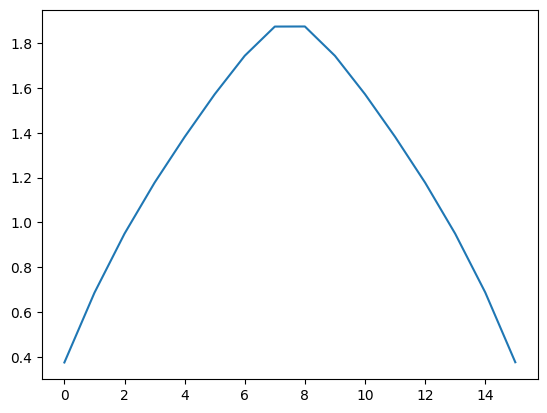

In [4137]:
plt.plot(entorpy_)

In [4136]:
n = 17 # three sites = three legs
d=2
chi=500
psi = np.random.rand(2**n)#+1j*np.random.rand(2**n)
psi = psi / np.linalg.norm(psi)  # random, normalized state vector
# psi = np.reshape(psi, (2, 2, 2)) # rewrite psi as rank-n tensor
entorpy_=[]
Us=[]
SS=[]

# reshape vector to matrix
psi_ = np.reshape(psi, (2, 2**(n-1)))
# SVD to split off first site
U, Lambda, Vd = np.linalg.svd(psi_, full_matrices=False)
# Uaa, Lambdaaa, Vdaa = np.linalg.svd(Vd, full_matrices=False)

# print(Lambda,U,Uaa,Lambdaaa,)

print(U.shape, Lambda.shape, Vd.shape,Lambda)

# chi_=Lambda.shape[0]
V_R=Vd.shape[1]
chitemp = min(chi, len(Lambda))
U = U[:, range(chitemp)].reshape(1,d,chitemp)
Vd = Vd[range(chitemp), :].reshape(chitemp,V_R)
Lambda=Lambda[range(chitemp)]
Lambda=Lambda/np.linalg.norm(Lambda)
SS.append(Lambda)
chi_=chitemp

entorpy_.append(-np.sum(Lambda**2*np.log(Lambda**2)))

Us = []
U = np.reshape(U, (1, d, chi_)) # mu1, s2, mu2
Us.append(U)

for i in range(n-1):
    psi_remainder = np.diag(Lambda) @ Vd                 # mu1 (s2 s3)
    psi_remainder = np.reshape(psi_remainder, (d*chi_, int(V_R*chitemp/(d*chi_))))  # (mu1 s2), s3
    U, Lambda, Vd = np.linalg.svd(psi_remainder, full_matrices=False)

    print(i,U.shape, Lambda.shape, Vd.shape)

    
    V_R=Vd.shape[1]
    chitemp = min(chi, len(Lambda))
    U = U[:, range(chitemp)].reshape(chi_,d,chitemp)
    Vd = Vd[range(chitemp), :].reshape(chitemp,V_R)
    Lambda=Lambda[range(chitemp)]
    Lambda=Lambda/np.linalg.norm(Lambda)
    SS.append(Lambda)
    chi_=chitemp


    print(i,U.shape, Lambda.shape, Vd.shape,np.linalg.norm(Lambda))

    if i!=n-2:
        entorpy_.append(-np.sum(Lambda**2*np.log(Lambda**2)))
        Us.append(U)
    else:
        Us.append(U*Lambda*Vd)
        print(Lambda,Vd)
    


# psi_remainder = np.diag(Lambda) @ Vd                 # mu1 (s2 s3)
# psi_remainder = np.reshape(psi_remainder, (2*2, 1))  # (mu1 s2), s3
# U, Lambda, Vd = np.linalg.svd(psi_remainder, full_matrices=False)

# U = np.reshape(U, (2, 2, 1)) # mu1, s2, mu2
# Us.append(U)

# U.shape, Lambda.shape, Vd.shape

(2, 2) (2,) (2, 65536) [0.9357937  0.35254807]
0 (4, 4) (4,) (4, 32768)
0 (2, 2, 4) (4,) (4, 32768) 1.0
1 (8, 8) (8,) (8, 16384)
1 (4, 2, 8) (8,) (8, 16384) 1.0
2 (16, 16) (16,) (16, 8192)
2 (8, 2, 16) (16,) (16, 8192) 1.0
3 (32, 32) (32,) (32, 4096)
3 (16, 2, 32) (32,) (32, 4096) 1.0
4 (64, 64) (64,) (64, 2048)
4 (32, 2, 64) (64,) (64, 2048) 1.0
5 (128, 128) (128,) (128, 1024)
5 (64, 2, 128) (128,) (128, 1024) 0.9999999999999999
6 (256, 256) (256,) (256, 512)
6 (128, 2, 256) (256,) (256, 512) 0.9999999999999999
7 (512, 256) (256,) (256, 256)
7 (256, 2, 256) (256,) (256, 256) 0.9999999999999999
8 (512, 128) (128,) (128, 128)
8 (256, 2, 128) (128,) (128, 128) 1.0
9 (256, 64) (64,) (64, 64)
9 (128, 2, 64) (64,) (64, 64) 1.0
10 (128, 32) (32,) (32, 32)
10 (64, 2, 32) (32,) (32, 32) 1.0
11 (64, 16) (16,) (16, 16)
11 (32, 2, 16) (16,) (16, 16) 1.0
12 (32, 8) (8,) (8, 8)
12 (16, 2, 8) (8,) (8, 8) 1.0
13 (16, 4) (4,) (4, 4)
13 (8, 2, 4) (4,) (4, 4) 1.0
14 (8, 2) (2,) (2, 2)
14 (4, 2, 2) (2,) 

In [2220]:
n = 9 # three sites = three legs
d=2
chi=500
psi = np.random.rand(2**n)#+1j*np.random.rand(2**n)
psi = psi / np.linalg.norm(psi)  # random, normalized state vector

In [2345]:

# psi = np.reshape(psi, (2, 2, 2)) # rewrite psi as rank-n tensor
Us=[]
entorpy_=[]

# reshape vector to matrix
psi_ = np.reshape(psi, (2, 2**(n-1)))
# SVD to split off first site
U, Lambda, Vd = np.linalg.svd(psi_, full_matrices=False)

print(U.shape, Lambda.shape, Vd.shape,np.linalg.norm(Lambda))

# chi_=Lambda.shape[0]
V_R=Vd.shape[1]
chitemp = min(chi, len(Lambda))
U = U[:, range(chitemp)].reshape(1,d,chitemp)
Vd = Vd[range(chitemp), :].reshape(chitemp,V_R)
Lambda=Lambda[range(chitemp)]
# Vd = Vd*np.sqrt(np.linalg.norm(Lambda))
# U = U*np.sqrt(np.linalg.norm(Lambda))
# Lambda=Lambda/np.linalg.norm(Lambda)
chi_=chitemp

entorpy_.append(-np.sum(Lambda**2*np.log(Lambda**2)))

Us = []
U = np.reshape(U, (1, d, chi_)) # mu1, s2, mu2
Us.append(U)
Us.append(Lambda)

for i in range(n-1):
    psi_remainder = Vd                 # mu1 (s2 s3)
    psi_remainder = np.reshape(psi_remainder, (d*chi_, int(V_R*chitemp/(d*chi_))))  # (mu1 s2), s3
    U, Lambda, Vd = np.linalg.svd(psi_remainder, full_matrices=False)

    print(i,U.shape, Lambda.shape, Vd.shape,np.linalg.norm(Lambda)**2)
        
    
    V_R=Vd.shape[1]
    chitemp = min(chi, len(Lambda))
    U = U[:, range(chitemp)].reshape(chi_,d,chitemp)
    Vd = Vd[range(chitemp), :].reshape(chitemp,V_R)
    norm_=np.sum(Lambda)
    Lambda=Lambda[range(chitemp)]
    # Vd = Vd*np.sqrt(np.linalg.norm(Lambda))
    # U = U*np.sqrt(np.linalg.norm(Lambda))
    # Lambda=Lambda/np.sum(Lambda)*norm_
    # Lambda=Lambda/np.linalg.norm(Lambda)
    chi_=chitemp


    print(i,U.shape, Lambda.shape, Vd.shape)

    
    if i!=n-2:
        entorpy_.append(-np.sum(Lambda**2*np.log(Lambda**2)))
        Us.append(U)
        Us.append(Lambda)
    else:
        Us.append(U*Lambda*Vd)
        print(Lambda,Vd)


# psi_remainder = np.diag(Lambda) @ Vd                 # mu1 (s2 s3)
# psi_remainder = np.reshape(psi_remainder, (2*2, 1))  # (mu1 s2), s3
# U, Lambda, Vd = np.linalg.svd(psi_remainder, full_matrices=False)

# U = np.reshape(U, (2, 2, 1)) # mu1, s2, mu2
# Us.append(U)

# U.shape, Lambda.shape, Vd.shape

(2, 2) (2,) (2, 256) 1.0000000000000002
0 (4, 4) (4,) (4, 128) 1.9999999999999996
0 (2, 2, 4) (4,) (4, 128)
1 (8, 8) (8,) (8, 64) 4.000000000000005
1 (4, 2, 8) (8,) (8, 64)
2 (16, 16) (16,) (16, 32) 7.999999999999998
2 (8, 2, 16) (16,) (16, 32)
3 (32, 16) (16,) (16, 16) 16.000000000000014
3 (16, 2, 16) (16,) (16, 16)
4 (32, 8) (8,) (8, 8) 16.000000000000007
4 (16, 2, 8) (8,) (8, 8)
5 (16, 4) (4,) (4, 4) 7.9999999999999964
5 (8, 2, 4) (4,) (4, 4)
6 (8, 2) (2,) (2, 2) 3.999999999999999
6 (4, 2, 2) (2,) (2, 2)
7 (4, 1) (1,) (1, 1) 2.0000000000000004
7 (2, 2, 1) (1,) (1, 1)
[1.41421356] [[1.]]


In [2533]:
fidelity2(Us,Us)

1.0000000000000018

In [2073]:
Us_left=vidal_to_left(Us)

In [2180]:
Us_=left_canonical_form(Us.copy())

(2, 2)
(2, 2) (2,) (2, 2)
(2, 2, 4)
(2, 2, 4)
(4, 2, 5)
(4, 2, 5)
(5, 2, 5)
(5, 2, 5)
(5, 2, 5)
(5, 2, 5)
(5, 2, 5)
(5, 2, 5)
(5, 2, 4)
(5, 2, 4)
(4, 2, 2)
(4, 2, 2)
(2, 2, 1)
check [1.+0.j] [[1.+0.j]]
(4, 1) (1,) (1, 1)
(4, 1)


In [2181]:
fidelity2(Us_,Us_)

1.0

In [2074]:
fidelity2(Us_left,Us_left)

0.999999999999995

In [2227]:
Us_1=Us.copy()

In [3]:
"""
mainTEBD.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian and MPS tensors before passing to
the TEBD routine.

by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 06/2020
"""

# preamble
import numpy as np
# from doTEBD import doTEBD
# from ncon import ncon

""" Example 1: XX model """

# set bond dimensions and simulation options
chi = 16  # bond dimension
tau = 0.1  # timestep

numiter = 500  # number of timesteps
evotype = "imag"  # real or imaginary time evolution
E0 = -4 / np.pi  # specify exact ground energy (if known)
midsteps = int(1 / tau)  # timesteps between MPS re-orthogonalization

# define Hamiltonian (quantum XX model)
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0, -1]])
hamAB = (np.real(np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)
hamBA = (np.real(np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)

# initialize tensors
d = hamAB.shape[0]
sAB = np.ones(chi) / np.sqrt(chi)
sBA = np.ones(chi) / np.sqrt(chi)
A = np.random.rand(chi, d, chi)
B = np.random.rand(chi, d, chi)

""" Imaginary time evolution with TEBD """
# run TEBD routine
A, B, sAB, sBA, rhoAB, rhoBA = doTEBD(hamAB, hamBA, A, B, sAB, sBA, chi,
    tau, evotype=evotype, numiter=numiter, midsteps=midsteps, E0=E0)

# continute running TEBD routine with reduced timestep
tau = 0.01
numiter = 2000
midsteps = 100
A, B, sAB, sBA, rhoAB, rhoBA = doTEBD(hamAB, hamBA, A, B, sAB, sBA, chi,
    tau, evotype=evotype, numiter=numiter, midsteps=midsteps, E0=E0)

# continute running TEBD routine with reduced timestep and increased bond dim
chi = 32
tau = 0.001
numiter = 20000
midsteps = 1000
A, B, sAB, sBA, rhoAB, rhoBA = doTEBD(hamAB, hamBA, A, B, sAB, sBA, chi,
    tau, evotype=evotype, numiter=numiter, midsteps=midsteps, E0=E0)

# compare with exact results
energyMPS = np.real(0.5 * ncon([hamAB, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]) +
                    0.5 * ncon([hamBA, rhoBA], [[1, 2, 3, 4], [1, 2, 3, 4]]))
enErr = abs(energyMPS - E0)
print('Final results => Bond dim: %d, Energy: %f, Energy Error: %e' %
      (chi, energyMPS, enErr))

iteration: 0 of 500, chi: 16, t-step: 0.100000, energy: 0.989111, energy error: 2.262351e+00
iteration: 10 of 500, chi: 16, t-step: 0.100000, energy: -1.250957, energy error: 2.228291e-02
iteration: 20 of 500, chi: 16, t-step: 0.100000, energy: -1.262659, energy error: 1.058093e-02
iteration: 30 of 500, chi: 16, t-step: 0.100000, energy: -1.263937, energy error: 9.302822e-03
iteration: 40 of 500, chi: 16, t-step: 0.100000, energy: -1.264327, energy error: 8.912958e-03
iteration: 50 of 500, chi: 16, t-step: 0.100000, energy: -1.264482, energy error: 8.757644e-03
iteration: 60 of 500, chi: 16, t-step: 0.100000, energy: -1.264553, energy error: 8.686614e-03
iteration: 70 of 500, chi: 16, t-step: 0.100000, energy: -1.264588, energy error: 8.651304e-03
iteration: 80 of 500, chi: 16, t-step: 0.100000, energy: -1.264607, energy error: 8.632775e-03
iteration: 90 of 500, chi: 16, t-step: 0.100000, energy: -1.264617, energy error: 8.622696e-03
iteration: 100 of 500, chi: 16, t-step: 0.100000, en

In [2781]:
chi=50

In [2819]:
import numpy as np
# initialize tensors
d = 2
chi = 10
N=9  # evennnn # saturates with odd, when single site hamiltonian ignored
A = np.zeros([chi, d, chi], dtype=np.complex64)
Ao = np.zeros([2, d, 1], dtype=np.complex64)
Ae = np.zeros([1, d, 2], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

######## # spin left
# A[0,0,0]=1/np.sqrt(2)
# A_edge_L[0,0,0]=1/np.sqrt(2)
# A_edge_R[0,0,0]=1/np.sqrt(2)
# A[0,1,0]=-1/np.sqrt(2)
# A_edge_L[0,1,0]=-1/np.sqrt(2)
# A_edge_R[0,1,0]=-1/np.sqrt(2)
######### # spin donw
A[0,0,0]=1
A_edge_R[0,0,0]=1
A_edge_L[0,0,0]=1
######### # spin right
# A[0,0,0]=1/np.sqrt(2)
# A_edge_L[0,0,0]=1/np.sqrt(2)
# A_edge_R[0,0,0]=1/np.sqrt(2)
# A[0,1,0]=1/np.sqrt(2)
# A_edge_L[0,1,0]=1/np.sqrt(2)
# A_edge_R[0,1,0]=1/np.sqrt(2)

Ae[0,0,0]=0
Ae[0,0,1]=-1/np.sqrt(2)
Ae[0,1,0]=1/np.sqrt(2)
Ae[0,1,1]=0

Ao[0,0,0]=1
Ao[1,0,0]=0
Ao[0,1,0]=0
Ao[1,1,0]=1


MPS=[]
for i in range(N):
    if i==0:
        MPS.append(A_edge_L)
    elif i==N-1:
        MPS.append(A_edge_R)
    else:
        MPS.append(A)
MPS[0].shape
# # Sample(MPS.copy(),[0,0,0,0,0,0,0,0])

# x_=np.random.rand(2,2)
# MPS=[Ao@x_,np.linalg.inv(x_)@Ae,Ao,Ae,Ao,Ae,Ao,Ae]
# MPS=[Ao if i%2!=0 else Ae for i in range (N)]

MPS_vid=vidal_form(MPS)
MPS_left,SS=left_canonical_form(MPS)

(2, 10)
1.4142135 1.4142135 1.0
(2, 2) (2,) (2, 10)
1.4142135 1.4142135
1.0 3.1622777
(10, 2, 1)
1.0
check [1.+0.j] [[1.+0.j]]
1.0
(20, 1) (1,) (1, 1)
(20, 1)
(2, 10)
(2, 2) (2,) (2, 10)
(10, 2, 10)
(2, 2, 10) 1.0
(10, 2, 10)
(4, 2, 10) 1.0
(10, 2, 10)
(8, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 10)
(10, 2, 10) 1.0
(10, 2, 1)
check [1.+0.j] [[1.+0.j]]
(20, 1) (1,) (1, 1)
(20, 1)


In [2702]:
MPS_up=MPS_left.copy()
SS_up=SS.copy()

In [2700]:
MPS_right=MPS_left.copy()
SS_right=SS.copy()

In [269]:
a=left_canonical_form(MPS_vid)
b=right_canonical_form(MPS_vid)

(2,)
(2, 2)
(1,)
(1, 1)
(2,)
(2, 2)
(1,)
(1, 1)
(2,)
(2, 2)
(1,)
(1, 1)
(2,)
(2, 2)


In [289]:
b[3]

array([[[-0.70710677+0.j],
        [ 0.        +0.j]],

       [[ 0.        +0.j],
        [ 0.70710677+0.j]]], dtype=complex64)

In [273]:
MPS_vid[2]

array([[[-0.70710677+0.j],
        [ 0.        +0.j]],

       [[ 0.        +0.j],
        [ 0.70710677+0.j]]], dtype=complex64)

In [1007]:
np.linalg.norm(Ao)

0.99999994

In [103]:
def Sample(MPS_,state):
    for i in range (len(state)):
        A=MPS_[i]
        chi_l,_,chi_r=A.shape
        MPS_[i]=A[:,int(state[i]),:].reshape(chi_l,chi_r)
        # print(MPS[i].shape,int(state[i]))
    # print(MPS)
    amplitude=ncon([MPS_[0],MPS_[1]],[[-1,1],[1,-2]])
    for i in range(2,len(state)):
        amplitude=ncon([amplitude,MPS_[i]],[[-1,1],[1,-2]])
    return amplitude.reshape([1])[0]

In [3997]:
def vidal_form(mps):
    mps=mps.copy()
    vidal_form = []
    A = mps[0]
    chi_L,_,chi_R=A.shape
    A_=A.reshape(chi_L*d,chi_R)
    # Perform SVD on A
    print(A_.shape)
    utemp, stemp, vhtemp = np.linalg.svd(A_, full_matrices=False)
    print(norm(np.conj(utemp.T)@utemp),np.linalg.norm(vhtemp),np.linalg.norm(stemp))
    print(utemp.shape,stemp.shape,vhtemp.shape)
    chitemp = min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)].reshape(chi_L,d,chitemp)
    vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R) # no change during reshape
    stemp=stemp[range(chitemp)]
    # stemp=stemp/np.linalg.norm(stemp)
    stemp=stemp.astype(np.complex64)
    vhtemp=vhtemp.astype(np.complex64)
    utemp=utemp.astype(np.complex64)

    print(np.linalg.norm(utemp),np.linalg.norm(vhtemp))
    
    vidal_form.append(utemp)
    vidal_form.append(stemp)

    # Process the remaining tensors
    for i in range(1, len(mps) - 1):
        B = mps[i]
        # print(B.shape)
        # print(np.linalg.norm(B.ravel()),np.linalg.norm(vhtemp.ravel()),norm((vhtemp@B).ravel()))
        B=ncon([vhtemp,B],[[-1,1],[1,-2,-3]])
        # print(np.linalg.norm(B))
        chi_L,_,chi_R=B.shape
        # print(B.shape)
        B_=B.reshape(chi_L*d,chi_R)
        # Contract B with the previous gamma matrix
        
        
        # Perform SVD on the reshaped tensor
        utemp, stemp, vhtemp = np.linalg.svd(B_, full_matrices=False)
        
        chitemp = min(chi, len(stemp))
        utemp = utemp[:, range(chitemp)].reshape(chi_L,d,chitemp)
        vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R)
        stemp=stemp[range(chitemp)]
        # stemp=stemp/np.linalg.norm(stemp)
        stemp=stemp.astype(np.complex64)
        vhtemp=vhtemp.astype(np.complex64)
        utemp=utemp.astype(np.complex64)
        
        vidal_form.append(utemp)
        vidal_form.append(stemp)
        
    # Process the last tensor (E)
    Z = mps[-1]
    print(np.linalg.norm(Z),np.linalg.norm(vhtemp))
    Z=ncon([vhtemp,Z],[[-1,1],[1,-2,-3]])
    chi_L,_,chi_R=Z.shape
    print(Z.shape)
    Z_=Z.reshape(chi_L*d,chi_R)
    print(np.linalg.norm(Z))
    
    utemp, stemp, vhtemp = np.linalg.svd(Z_, full_matrices=False)
    # Z_=utemp

    chitemp = len(stemp)#min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)]
    vhtemp = vhtemp[range(chitemp), :]
    stemp=stemp[range(chitemp)]
    # stemp=stemp/np.linalg.norm(stemp)
    stemp=stemp.astype(np.complex64)
    vhtemp=vhtemp.astype(np.complex64)
    utemp=utemp.astype(np.complex64)

    print("check",stemp,vhtemp)
    
    Z_=utemp@np.diag(stemp)@vhtemp
    print(np.linalg.norm(Z_))
    print(utemp.shape,stemp.shape,vhtemp.shape)
    print(Z_.shape)
    vhtemp=Z_.reshape(chi_L,d,chi_R)
    
    vidal_form.append(vhtemp)

    return vidal_form

def left_canonical_form(mps):
    mps=mps.copy()
    vidal_form = []
    SS=[]
    A = mps[0]
    chi_L,_,chi_R=A.shape
    A_=A.reshape(chi_L*d,chi_R)
    # Perform SVD on A
    # print(A_.shape)
    utemp, stemp, vhtemp = np.linalg.svd(A_, full_matrices=False)
    # print(utemp.shape,stemp.shape,vhtemp.shape)
    chitemp = min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)].reshape(chi_L,d,chitemp)
    vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R) # no change during reshape
    stemp=stemp[range(chitemp)]
    stemp=stemp/np.linalg.norm(stemp)
    SS.append(stemp)
    vhtemp=np.diag(stemp)@vhtemp
    stemp=stemp.astype(np.complex64)
    vhtemp=vhtemp.astype(np.complex64)
    utemp=utemp.astype(np.complex64)
    
    vidal_form.append(utemp)
    
    # Process the remaining tensors
    for i in range(1, len(mps) - 1):
        B = mps[i]
        # print(B.shape)
        B=ncon([vhtemp,B],[[-1,1],[1,-2,-3]])
        chi_L,_,chi_R=B.shape
        # print(B.shape,np.linalg.norm(stemp))
        B_=B.reshape(chi_L*d,chi_R)
        # Contract B with the previous gamma matrix
        
        
        # Perform SVD on the reshaped tensor
        utemp, stemp, vhtemp = np.linalg.svd(B_, full_matrices=False)
        
        chitemp = min(chi, len(stemp))
        utemp = utemp[:, range(chitemp)].reshape(chi_L,d,chitemp)
        vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R)
        stemp=stemp[range(chitemp)]
        stemp=stemp/np.linalg.norm(stemp)
        SS.append(stemp)
        vhtemp=np.diag(stemp)@vhtemp
        stemp=stemp.astype(np.complex64)
        vhtemp=vhtemp.astype(np.complex64)
        utemp=utemp.astype(np.complex64)
        
        vidal_form.append(utemp)
        
    # Process the last tensor (E)
    Z = mps[-1]
    Z=ncon([vhtemp,Z],[[-1,1],[1,-2,-3]])
    chi_L,_,chi_R=Z.shape
    # print(Z.shape)
    Z_=Z.reshape(chi_L*d,chi_R)
    
    utemp, stemp, vhtemp = np.linalg.svd(Z_, full_matrices=False)
    # Z_=utemp

    chitemp = len(stemp)#min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)]
    vhtemp = vhtemp[range(chitemp), :]
    stemp=stemp[range(chitemp)]
    stemp=stemp/np.linalg.norm(stemp)
    SS.append(stemp)
    stemp=stemp.astype(np.complex64)
    vhtemp=vhtemp.astype(np.complex64)
    utemp=utemp.astype(np.complex64)
    
    print("check",stemp,vhtemp)
    
    Z_=utemp@np.diag(stemp)@vhtemp
    # print(utemp.shape,stemp.shape,vhtemp.shape)
    # print(Z_.shape)
    vhtemp=Z_.reshape(chi_L,d,chi_R)

    vidal_form.append(vhtemp)

    return vidal_form, SS

In [2962]:
chi = 70  # bond dimension
d = 2
N=10

A = np.random.rand(chi,d,chi)+1j*np.random.rand(chi,d,chi)
# A=A/np.linalg.norm(A)
A_edge_R = np.random.rand(chi,d,1)+1j*np.random.rand(chi,d,1)
# A_edge_R=A_edge_R/np.linalg.norm(A_edge_R)
A_edge_L = np.random.rand(1,d,chi)+1j*np.random.rand(1,d,chi)
# A_edge_L=A_edge_L/np.linalg.norm(A_edge_L)
MPS=[]
for i in range(N):
    if i==0:
        MPS.append(A_edge_L)
    elif i==N-1:
        MPS.append(A_edge_R)
    else:
        MPS.append(A)
# for i in range(N):
#     MPS[i]=MPS[i].astype(np.complex64)

# Sample(MPS,np.zeros([N]))
# MPS=vidal_form(MPS)
MPS_vid=vidal_form(MPS)
MPS_left,SS=left_canonical_form(MPS)
np.linalg.norm(A)

(2, 70)
1.4142135623730951 1.414213562373095 9.32131020856037
(2, 2) (2,) (2, 70)
1.4142135 1.4142134
10.094582206817309 8.366604
(70, 2, 1)
10.09458222954951
check [10.094583+0.j] [[1.+0.j]]
10.094583
(140, 1) (1,) (1, 1)
(140, 1)
(2, 70)
(2, 2) (2,) (2, 70)
(70, 2, 70)
(2, 2, 70) 1.0
(70, 2, 70)
(4, 2, 70) 0.99999994
(70, 2, 70)
(8, 2, 70) 1.0
(70, 2, 70)
(16, 2, 70) 1.0
(70, 2, 70)
(32, 2, 70) 1.0
(70, 2, 70)
(64, 2, 70) 1.0
(70, 2, 70)
(70, 2, 70) 1.0
(70, 2, 70)
(70, 2, 70) 1.0
(70, 2, 1)
check [1.+0.j] [[1.+0.j]]
(140, 1) (1,) (1, 1)
(140, 1)


80.55951663836532

In [1248]:
MPS_left=left_canonical_form(MPS_left)

(2, 2)
(2, 2) (2,) (2, 2)
(2, 2, 4)
(2, 2, 4)
(4, 2, 1)
check [1.+0.j] [[1.+0.j]]
(8, 1) (1,) (1, 1)
(8, 1)


In [1047]:
MPS_vid[2].shape

(2, 2, 4)

In [1578]:
MPS=MPS_vid

In [1579]:
sum_=0
for i in range(len(MPS)):
    print(MPS[i].shape)
    if i%2!=0:
        print('a')
        print(np.dot(MPS[i],MPS[i]))
# for i in range(len(MPS)):
#     # print(MPS[i].shape)
#     if i%2!=0:
#         # print('a')
#         MPS[i]=MPS[i]/np.sqrt(np.real(sum_))
print(len(MPS),sum_)

(1, 2, 2)
(2,)
a
(1+0j)
(2, 2, 2)
(2,)
a
(0.99999994+0j)
(2, 2, 1)
5 0


In [4880]:
#lenght(MPS) is always odd in canonical form

def get_Gammas(MPS_):
    MPS_=MPS_.copy()
    mps=[]
    mps.append(MPS_[0])
    for i in range(1,len(MPS_),2):
        # lambda_=MPS_[i]
        gamma_=MPS_[i+1]
        # print(b.shape)
        # lambda_=np.diag(lambda_)
        # print(b.shape)
        # c=ncon([lambda_,gamma_],[[-1,1],[1,-2,-3]])
        c=gamma_
        mps.append(c)
    return mps

def vidal_to_left(MPS_):
    MPS_=MPS_.copy()
    mps=[]
    mps.append(MPS_[0])
    for i in range(1,len(MPS_),2):
        lambda_=MPS_[i]
        gamma_=MPS_[i+1]
        # print(lambda_,gamma_)
        lambda_=np.diag(lambda_)
        # print(b.shape)
        c=ncon([lambda_,gamma_],[[-1,1],[1,-2,-3]])
        # print(c)
        mps.append(c)
        # brbg
    return mps

def left_to_vidal(MPS_): # incomplete
    MPS_=MPS_.copy()
    mps=[]
    mps.append(MPS_[0])
    for i in range(1,len(MPS_)):
        A=MPS_[i]
        chi_L,_,chi_R=A.shape
        A=A.reshape(chi_L*d,chi_R)
        utemp, stemp, vhtemp = np.linalg.svd(A, full_matrices=False)
        
        utemp = utemp.reshape(chi_L,d,chitemp)
        vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R)
        # print(lambda_,gamma_)
        lambda_=np.diag(lambda_)
        # print(b.shape)
        c=ncon([lambda_,gamma_],[[-1,1],[1,-2,-3]])
        # print(c)
        mps.append(c)
        # brbg
    return mps
    

def get_Lambdas(MPS_):
    MPS_=MPS_.copy()
    mps=[]
    mps.append(MPS_[1])
    for i in range(3,len(MPS_),2):
        lambda_=MPS_[i]
        # gamma_=MPS_[i+1]
        # print(b.shape)
        # lambda_=np.diag(lambda_)
        # print(b.shape)
        # c=ncon([lambda_,gamma_],[[-1,1],[1,-2,-3]])
        # c=gamma_
        mps.append(lambda_)
    return mps

def fidelity(MPS_A,MPS_B,canonical='vidal'):
    MPS_A=MPS_A.copy()
    MPS_B=MPS_B.copy()
    # if len(MPS_A)!=len(MPS_B):
    #     print("error sjdl")
    # print(MPS_A[0].shape,len(MPS_A))
    if canonical=='vidal':
        L_A=get_Lambdas(MPS_A)
        L_B=get_Lambdas(MPS_B)
        MPS_A=get_Gammas(MPS_A)
        MPS_B=get_Gammas(MPS_B)
    
    for i in range(len(MPS_B)):
        # L_B[i]=np.conj(L_B[i]) # already real
        MPS_B[i]=np.conj(MPS_B[i])
    
    # print(MPS_A[0].shape,len(MPS_A))
    if len(MPS_A)!=len(MPS_B):
        print("error sjdl")
    MPS_=[]
    for i in range(len(MPS_A)):
        # print(i)
        MPS_.append(ncon([(MPS_A[i]),(MPS_B[i])],[[-1,1,-2],[-4,1,-3]]))
    print(MPS_[0].reshape(2,2),MPS_[-1].shape)
    # print()
    # print(MPS_[1])
    # print(ncon([MPS_[1]],[[1,-1,-2,1]]),'a')

    Norm=ncon([MPS_[0],MPS_[1]],[[-1,1,2,-4],[1,-2,-3,2]])
    # print(Norm)#,ncon([MPS_[0],MPS_[1]],[[-1,1,2,-4],[1,-2,-3,2]]))
    for i in range(2,len(MPS_)):
        Norm=ncon([Norm,MPS_[i]],[[-1,1,2,-4],[1,-2,-3,2]])

    # Norm2=ncon([L_A[0],L_A[1]],[[-1,1],[1,-2]])
    # for i in range(2,len(L_A)):
    #     Norm2=ncon([Norm2,L_A[i]],[[-1,1],[1,-2]])

    # Norm3=ncon([L_B[0],L_B[1]],[[-1,1],[1,-2]])
    # for i in range(2,len(L_B)):
    #     Norm3=ncon([Norm3,L_B[i]],[[-1,1],[1,-2]])
    # Norm_=ncon([Norm2,Norm3],[[1,2],[1,2]])

    # Norm_=0
    # for i in range(0,len(L_A)):
    #     Norm_=Norm_+np.dot(L_A[i],np.conj(L_B[i]))
    # Norm_=Norm_/(N-1)
        

    # print(Norm.shape,Norm)
    # return Norm_
    return np.real(Norm.reshape(1)[0])

def fidelity1(MPS_A,MPS_B):
    MPS_A=MPS_A.copy()
    MPS_B=MPS_B.copy()
    for i in range(len(MPS_B)):
        MPS_B[i]=np.conj(MPS_B[i])
        if i%2!=0:
            MPS_B[i]=np.diag(MPS_B[i])
            MPS_A[i]=np.diag(MPS_A[i])
    Norm=ncon([MPS_A[0],MPS_B[0]],[[1,2,-1],[1,2,-2]])
    # print(Norm)
    Norm=ncon([Norm,MPS_A[1],MPS_B[1]],[[1,2],[1,-1],[2,-2]])
    # print(Norm,MPS_A[1]@MPS_B[1],ncon([Norm],[[1,1]]),np.sum(MPS_A[1]**2))
    Norm=ncon([Norm,MPS_A[2],MPS_B[2]],[[1,2],[1,3,-1],[2,3,-2]])
    # D=ncon([MPS_A[2],MPS_B[2]],[[-1,1,-2],[-4,1,-3]])
    # E=ncon([MPS_A[4],MPS_B[4]],[[-1,1,-2],[-4,1,-3]])
    # E=ncon([MPS_A[0],MPS_B[0]],[[-1,1,-2],[-4,1,-3]])
    # print(Norm,ncon([Norm],[[1,1]]),'a',ncon([D],[[1,-1,-2,1]]),'b',ncon([E],[[1,-1,-2,1]]))
    for i in range(3,len(MPS_A),2):
        Norm=ncon([Norm,MPS_A[i],MPS_B[i]],[[1,2],[1,-1],[2,-2]])
        # print(Norm,MPS_A[i]@MPS_B[i],ncon([Norm],[[1,1]]),np.sum(MPS_A[i]**2))
        Norm=ncon([Norm,MPS_A[i+1],MPS_B[i+1]],[[1,3],[1,2,-1],[3,2,-2]])
        # print(Norm,ncon([Norm],[[1,1]]))

    # print(Norm)

    # Norm=ncon([MPS_A[0],MPS_B[0]],[[1,2,-1],[1,2,-2]])
    # Norm=ncon([Norm,MPS_A[1],MPS_B[1]],[[1,2],[1,-1],[2,-2]])
    # Normr=ncon([MPS_A[4],MPS_B[4]],[[-1,2,1],[-2,2,1]])
    # Normr=ncon([Normr,MPS_A[3],MPS_B[3]],[[1,2],[-1,1],[-2,2]])
    # Normrr=ncon([MPS_A[2],MPS_B[2],Normr],[[-1,1,2],[-2,1,3],[2,3]])
    # Normrr=ncon([Norm,Normrr],[[1,2],[1,2]])
    # Norm=ncon([Norm,MPS_A[2],MPS_B[2],Normr],[[1,2],[1,3,4],[2,3,5],[4,5]])

    
    # Norm=ncon(MPS_A+MPS_B,[[1,11,2],[2,3],[3,12,4],[4,5],[5,13,6]   ,[1,11,7],[7,8],[8,12,9],[9,10],[10,13,6]])
    
    
    # print(Norm)
    return np.real(ncon([Norm],[[1,1]]))

def fidelity2(MPS_A,MPS_B):
    MPS_A=MPS_A.copy()
    MPS_B=MPS_B.copy()
    for i in range(len(MPS_B)):
        MPS_B[i]=np.conj(MPS_B[i])
    Norm=ncon([MPS_A[0],MPS_B[0]],[[1,2,-1],[1,2,-2]])
    for i in range(1,len(MPS_A)):
        Norm=ncon([Norm,MPS_A[i],MPS_B[i]],[[1,3],[1,2,-1],[3,2,-2]])
    return (ncon([Norm],[[1,1]]))

def fidelity3(MPS_A,MPS_B):
    MPS_A=MPS_A.copy()
    MPS_B=MPS_B.copy()
    for i in range(len(MPS_B)):
        if i%2==0:
            MPS_B[i]=np.conj(MPS_B[i])
        if i%2!=0:
            MPS_B[i]=np.diag(MPS_B[i])
            MPS_A[i]=np.diag(MPS_A[i])
    # print(MPS_A[1])
    Norm=ncon([MPS_A[0],MPS_B[0]],[[1,2,-1],[1,2,-2]])
    for i in range(1,len(MPS_A),2):
        A=ncon([MPS_A[i],MPS_A[i+1]],[[-1,1],[1,-2,-3]])
        B=ncon([MPS_B[i],MPS_B[i+1]],[[-1,1],[1,-2,-3]])
        # print(A)
        # print(Norm,MPS_A[i]@MPS_B[i],ncon([Norm],[[1,1]]),np.sum(MPS_A[i]**2))
        Norm=ncon([Norm,A,B],[[1,3],[1,2,-1],[3,2,-2]])
    return (ncon([Norm],[[1,1]]))

In [2692]:
# fid1=fidelity(MPS_left,MPS_left,'left')
fid1=fidelity2(MPS_left,MPS_left)
fid2=fidelity1(MPS_vid,MPS_vid)
fid4=fidelity3(MPS_vid,MPS_vid)
MPS_v_l=vidal_to_left(MPS_vid)
fid3=fidelity2(MPS_v_l,MPS_v_l)
[fid1, fid2, fid3,fid4]

[0.9999998807907104,
 0.9999998807907104,
 0.9999998807907104,
 0.9999998807907104]

In [1819]:
Sample(MPS.copy(),[1,0,1,0,1,0,1,0])
Sample(MPS.copy(),[0,1,0,1,0,1,0,1])

(0.24999997+0j)

In [2576]:
fid=fidelity2(MPS_vid_old,MPS_vid_old)
fidelity2(MPS_vid_old,MPS_vid_old)

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [1896]:
A=np.random.rand(10,10)
B=np.random.rand(10,10)
C=A@B
C-ncon([A,B],[[-1,1],[1,-2]])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [1708]:
MPS_vid[1]/np.sqrt(fid2)

array([2.6238515+0.j, 0.6947179+0.j], dtype=complex64)

In [2580]:
MPS_vid=MPS2.copy()
for i in range(len(MPS_vid)):
    MPS_vid[i]=MPS_vid[i]/fid**(1/(2*(N)))
fidelity2(MPS_vid,MPS_vid)

1.000000000000001

In [2574]:
MPS_vid=MPS2.copy()
for i in range(len(MPS_vid)):
    # if i%2==0:
    #     print(i)
    #     A=MPS_vid[i]
    #     if i==0:
    #         sA=np.array([1])
    #     else:
    #         sA=MPS_vid[i-1]
    #     if i==len(MPS_vid)-1:
    #         sAB=np.array([1])
    #     else:
    #         sAB=MPS_vid[i+1]
    #     sA=sA#/fid2**(1/(2*(N-1)))
    #     sAB=sAB#/fid2**(1/(2*(N-1)))
    #     print(sA.shape,sAB.shape,A.shape)
    #     A_norm = np.sqrt(np.real(ncon([np.diag(sA**2), A, np.conj(A), np.diag(sAB**2)],[[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]])))
    #     MPS_vid[i] = A / A_norm #/np.sqrt(np.sqrt(np.sqrt(np.sqrt(np.sqrt(fid2)))))
    #     # print(A_norm)
    if i%2!=0:
        MPS_vid[i]=MPS_vid[i]/fid2**(1/(2*(N-1)))
fidelity2(MPS_vid,MPS_vid)

/tmp/ipykernel_93868/315558756.py:21: RuntimeWarning: invalid value encountered in divide
  MPS_vid[i]=MPS_vid[i]/fid2


nan

In [2573]:
N

16

In [139]:
a=np.random.rand(10,11,3,2)+1j*np.random.rand(10,11,3,2)
np.linalg.norm(a)**2-ncon([np.conj(a),(a)],[[1,2,3,4],[1,2,3,4]])

(5.684341886080802e-14+0j)

In [ ]:
n = 3 # three sites = three legs
psi = np.random.rand(2**3)+1j*np.random.rand(2**3)
psi = psi / np.linalg.norm(psi)  # random, normalized state vector
psi = np.reshape(psi, (2, 2, 2)) # rewrite psi as rank-n tensor

In [2571]:
MPS2=MPS_vid_old.copy()

In [1867]:
MPS2=MPS_vid.copy()

In [1529]:
MPS_vid=MPS2.copy()

In [456]:
MPS1=MPS_left

In [2820]:
def entagelement_entropy(MPS_):
    MPS_=MPS_.copy()
    MPS_=get_Lambdas(MPS_)
    # print(len(MPS_),MPS_[0])
    entropy=np.zeros([len(MPS_)])
    for i in range(len(MPS_)):
        # print((MPS_[i]))
        entropy[i]=-np.sum(MPS_[i]**2*np.log(MPS_[i]**2))
    plt.plot(range(len(MPS_)),entropy)
    
    return entropy

def entagelement_entropy1(MPS_):
    MPS_=MPS_.copy()
    MPS_=get_Lambdas(MPS_)
    # print(len(MPS_),MPS_[0])
    entropy=np.zeros([len(MPS_)])
    for i in range(len(MPS_)):
        # print((MPS_[i]))
        x=MPS_[i][MPS_[i]>1e-20]
        entropy[i]=-np.sum(x**2*np.log(x**2))
        # entropy[i]=-np.sum(MPS[i]**2*np.log(MPS[i]**2))
    plt.plot(range(len(MPS_)),entropy)
    
    return entropy

def entagelement_entropy2(MPS_):
    MPS_=MPS_.copy()
    # print(len(MPS_),MPS_[0])
    # entropy=np.zeros([len(MPS_)])
    # for i in range(len(MPS_)):
    #     A=MPS_[i]
    #     chi_L,_,chi_R=A.shape
    #     A=A.reshape(chi_L,chi_R*d)
    #     utemp, stemp, vhtemp = np.linalg.svd(A, full_matrices=False)
    #     print(norm(utemp),norm(stemp),norm(vhtemp),utemp.shape,vhtemp.shape)
    #     # x=np.diagonal(utemp@np.diag(stemp))
    #     x=stemp
    #     # x=stemp[stemp>1e-20]
    #     entropy[i]=-np.sum(x**2*np.log(x**2))
    #     # entropy[i]=-np.sum(MPS[i]**2*np.log(MPS[i]**2))
    # plt.plot(range(len(MPS_)),entropy)

    # entropy=[]
    # A=MPS_[-1]
    # chi_L,_,chi_R=A.shape
    # A=A.reshape(chi_L,chi_R*d)
    # utemp, stemp, vhtemp = np.linalg.svd(A, full_matrices=False)
    # print(utemp.shape,vhtemp.shape)
    # x=stemp
    # entropy.append(-np.sum(x**2*np.log(x**2)))
    
    # for i in range(len(MPS_)-2,-1,-1):
    #     A=MPS_[i]
    #     chi_L,_,chi_R=A.shape
    #     print(A.shape)
    #     A=A.reshape(chi_L,chi_R)
    #     print(chi_L,d,chi_R,utemp.shape)
    #     A=A@utemp@np.diag(stemp)
    #     utemp, stemp, vhtemp = np.linalg.svd(A, full_matrices=False)
    #     print(utemp.shape,vhtemp.shape)
    #     x=stemp
    #     entropy.append(-np.sum(x**2*np.log(x**2)))

    entropy=[]
    stemp=np.array([1])
    utemp=MPS_[-1]
    for i in range(len(MPS_)-1,0,-1):
    # for i in range(1,len(MPS_)):
        # print(i)
        A=MPS_[i-1]
        # B=MPS_[i]
        # print(stemp.shape,B.shape[2])
        ## B=ncon([B,np.diag(stemp)],[[-1,-2,1],[1,-3]])
        B=ncon([utemp,np.diag(stemp)],[[-1,-2,1],[1,-3]])
        # print(A.shape,stemp.shape)
        # # A=ncon([np.diag(stemp),A],[[-1,1],[1,-2,-3]])
        chi_L,_,chi_ll=A.shape
        chi_rr,_,chi_R=B.shape
        C=ncon([A,B],[[-1,-2,1],[1,-3,-4]])
        C=C.reshape(d*chi_L,d*chi_R)
        utemp, stemp, vhtemp = np.linalg.svd(C, full_matrices=False)
        chitemp = min(chi, len(stemp))
        utemp = utemp[:, range(chitemp)]
        vhtemp = vhtemp[range(chitemp), :]
        # print(np.linalg.norm(stemp))
        stemp = stemp[range(chitemp)] / np.linalg.norm(stemp[range(chitemp)])
        # print(norm(A.reshape(chi_L*d,chi_ll)-utemp),norm(B.reshape(chi_rr,chi_R*d)-vhtemp))
        # x=stemp
        x=stemp[stemp>1e-14]
        # print(stemp.shape,norm(stemp))
        entropy.append(-np.sum(x**2*np.log(x**2)))
        chi__=stemp.shape[0]
        utemp=utemp.reshape(chi_L,d,chi__)
        
    plt.plot(range(len(MPS_)-1),list(reversed(entropy)))

    return list(reversed(entropy))

def entagelement_entropy3(S):
    S=S.copy()
    entropy=np.zeros([len(S)-1])
    for i in range(len(S)-1):
        # print((MPS_[i]))
        x=S[i][S[i]>1e-20]
        entropy[i]=-np.sum(x**2*np.log(x**2))
    # plt.plot(range(len(S)-1),entropy)
    
    return entropy

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.28056406e-29,  3.60476248e-29,  3.60476248e-29,  3.60476248e-29,
        3.60476248e-29])

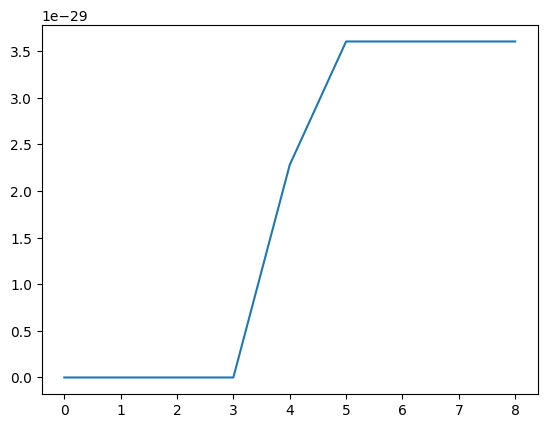

In [2688]:
entagelement_entropy3(SS)

array([-2.36591724e-01, -4.45100913e-01, -6.29057365e-01, -7.92491760e-01,
       -9.46943745e-01, -8.74935178e-01, -5.06391014e-01, -2.55273016e-01,
       -9.93923049e-02, -1.74883772e-02,  1.11022302e-16,  2.22044605e-16,
       -3.88578059e-16, -1.66533454e-16, -1.94289029e-16,  5.55111512e-17])

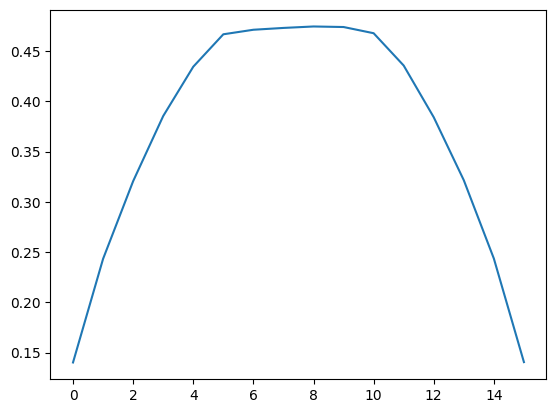

In [2547]:
entorpy__=entagelement_entropy2(Us)
np.array(entorpy__)-np.array(entorpy_)

[0.10989365961257845,
 0.14387251329927894,
 0.14368183638505616,
 0.1432251319952673,
 0.14333795584746037,
 0.14322176622489172,
 0.14334182338201676,
 0.14322383399190525,
 0.1433422422598725,
 0.14322400252713985,
 0.1433365574556569,
 0.14321332426886602,
 0.1437586548633743,
 0.14403436448887227,
 0.10784666940635382]

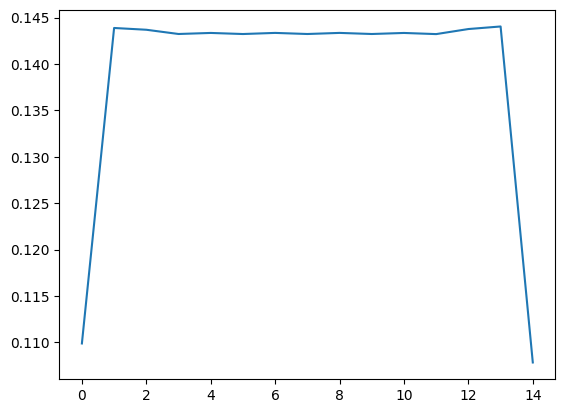

In [2555]:
entagelement_entropy2(MPS_vid_old)

[0.00045171752968202526,
 1.2431776019662536e-05,
 3.5409871791848326e-06,
 3.4074310522740797e-06,
 3.43860055057695e-06,
 3.4378877571080205e-06,
 3.4379254268464666e-06,
 3.4379291311775005e-06,
 3.437936840189422e-06,
 3.4379059872481272e-06,
 3.438502608057445e-06,
 3.4488456229161496e-06,
 3.341619389325505e-06,
 1.6213471951641286e-05,
 0.00037299323298207315]

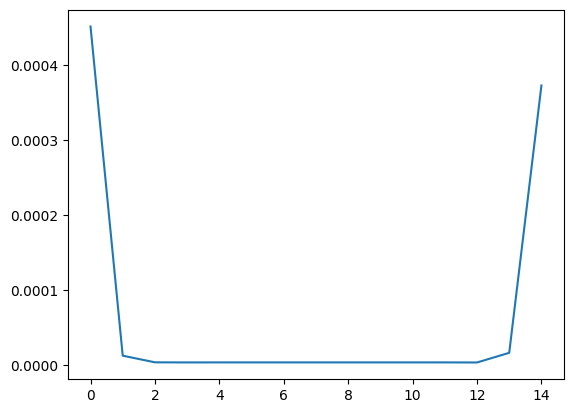

In [2551]:
entagelement_entropy2(MPS_left)

In [1019]:
numiter = 500  # number of timesteps
dt=0.01
E0 = -4 / np.pi  # specify exact ground energy (if known)

# define Hamiltonian (quantum XX model)
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0, -1]])
I=np.array([[1, 0], [0, 1]])
ham = ((np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)
ham_last = ((I)).reshape(2, 2)

gate_even = expm(-1 * dt/2 * ham.reshape(d**2, d**2)).reshape(d, d, d, d)
gate_odd = expm(-1 * dt * ham.reshape(d**2, d**2)).reshape(d, d, d, d)
gate_even_last = expm(-1 * dt/2 * ham_last.reshape(d, d)).reshape(d, d)
gate_odd_last = expm(-1 * dt * ham_last.reshape(d, d)).reshape(d, d)

In [2581]:
def Normalize(MPS_left):
    MPS_=MPS_left.copy()
    Normm=fidelity2(MPS_,MPS_)
    for i in range(len(MPS_)):
        MPS_[i]=MPS_[i]/Normm**(1/(2*(N)))
        

    return MPS_

In [3678]:
def apply_gate_MPS(sA, A, sAB, B, sB, gateAB, stol=1e-7):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""
    
    # ensure singular values are above tolerance threshold
    sA_trim = sA * (sA > stol) + stol * (sA < stol)
    sB_trim = sB * (sB > stol) + stol * (sB < stol)
    
    # contract gate into the MPS, then deompose composite tensor with SVD
    # d = A.shape[1]
    chiA = sA_trim.shape[0]
    chiB = sB_trim.shape[0]
    tensors = [np.diag(sA_trim), A, np.diag(sAB), B, np.diag(sB_trim), gateAB]
    connects = [[-1, 1], [1, 5, 2], [2, 4], [4, 6, 3], [3, -4], [-2, -3, 5, 6]]
    nshape = [d * chiA, d * chiB]
    utemp, stemp, vhtemp = np.linalg.svd(ncon(tensors, connects).reshape(nshape),full_matrices=False)
    
    # truncate to reduced dimension
    chitemp = min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)].reshape(chiA, d * chitemp)
    vhtemp = vhtemp[range(chitemp), :].reshape(chitemp * d, chiB)
    
    # remove environment weights to form new MPS tensors A and B
    A = (np.diag(1 / sA_trim) @ utemp).reshape(chiA, d, chitemp)
    B = (vhtemp @ np.diag(1 / sB_trim)).reshape(chitemp, d, chiB)
    
    # new weights
    sAB = stemp[range(chitemp)] / np.linalg.norm(stemp[range(chitemp)])


    
    # A_norm = np.sqrt(ncon([np.diag(sA**2), A, np.conj(A), np.diag(sAB**2)],
    #                     [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
    # A = A / A_norm
    # B_norm = np.sqrt(ncon([np.diag(sAB**2), B, np.conj(B), np.diag(sB**2)],
    #                     [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
    # B = B / B_norm
    
    return A, sAB, B

def apply_last_gate_MPS(sA, A, sB, gateAB, stol=1e-7):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""
    
    # ensure singular values are above tolerance threshold
    sA_trim = sA * (sA > stol) + stol * (sA < stol)
    sB_trim = sB * (sB > stol) + stol * (sB < stol)
    
    # contract gate into the MPS, then deompose composite tensor with SVD
    # d = A.shape[1]
    chiA = sA_trim.shape[0]
    chiB = sB_trim.shape[0]
    tensors = [np.diag(sA_trim), A, np.diag(sB_trim), gateAB]
    connects = [[-1, 1], [1, 4, 2], [2, -3], [-2, 4]]
    nshape = [d*chiA, chiB]
    # utemp, stemp, vhtemp = np.linalg.svd(ncon(tensors, connects).reshape(nshape),full_matrices=False)
    
    # # truncate to reduced dimension
    # chitemp = min(chi, len(stemp))
    # utemp = utemp[:, range(chitemp)].reshape(chiA, d * chitemp)
    # vhtemp = vhtemp[range(chitemp), :].reshape(chitemp, chiB)
    
    # # remove environment weights to form new MPS tensors A and B
    # A = (np.diag(1 / sA_trim) @ utemp).reshape(chiA, d, chitemp)
    # B = (vhtemp @ np.diag(1 / sB_trim)).reshape(chitemp, chiB)
    
    # # new weights
    # sAB = stemp[range(chitemp)] / np.linalg.norm(stemp[range(chitemp)])

    A=ncon(tensors, connects)
    A=A.reshape(chiA,d*chiB)
    A = (np.diag(1 / sA_trim) @A)
    A=A.reshape(chiA,d,chiB)

    # A_norm = np.sqrt(ncon([np.diag(sA_trim**2), A, np.conj(A), np.diag(sB_trim**2)],
    #                     [[1, 3], [1, 4, 2], [3, 4, 5], [2, 5]]))
    # A = A / A_norm
    
    return A




def apply_gate_MPS_left(A, B, SS, gateAB, stol=1e-7,dont_normalize=0):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""

    SS = SS * (SS > stol) + stol * (SS < stol)
    
    chiA,_,_=A.shape
    _,_,chiB=B.shape
    tensors = [A, B, np.diag(SS), gateAB]
    connects = [[-1, 3, 2], [2, 4, 5], [5,-4], [-2, -3, 3, 4]]
    nshape = [d * chiA, d * chiB]
    utemp, stemp, vhtemp = np.linalg.svd(ncon(tensors, connects).reshape(nshape),full_matrices=False)
    
    # truncate to reduced dimension
    chitemp = min(chi, len(stemp),np.sum(stemp>stol))
    utemp = utemp[:, range(chitemp)].reshape(chiA, d * chitemp)
    vhtemp = vhtemp[range(chitemp), :]
    # print(np.linalg.norm(stemp))
    # print(stemp.shape,'a')
    norm_=np.linalg.norm(stemp)
    if dont_normalize!=0:
        stemp = stemp[range(chitemp)]#/ np.linalg.norm(stemp)*norm_
    else:
        stemp = stemp[range(chitemp)]/ np.linalg.norm(stemp)#*norm_
    # print(stemp.shape,stemp)
    # print(SS.shape,vhtemp.shape,stemp.shape,chiB,vhtemp.reshape(chitemp,d,chiB).shap)
    vhtemp=ncon([np.diag(stemp),vhtemp.reshape(chitemp,d,chiB),np.diag(1/SS)],[[-1,1],[1,-2,2],[2,-3]])
    # vhtemp=(vhtemp).reshape(chitemp * d, chiB)

    # new weights
    
    # remove environment weights to form new MPS tensors A and B
    A = (utemp).reshape(chiA, d, chitemp)
    B = (vhtemp).reshape(chitemp, d, chiB)
    
    return A, stemp, B

def apply_last_gate_MPS_left(A, gateAB, stol=1e-7):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""
    
    chiA,_,chiB=A.shape
    tensors = [A, gateAB]
    connects = [[-1, 1, -3], [1,-2]]
    A=ncon(tensors, connects)
    
    return A

In [3077]:
def apply_hamiltonian(MPS_vid,gate,gate_last,odd_even):
    MPS_vid=MPS_vid.copy()
    if odd_even=="even":
        # print("even")
        iniit=0
    else:
        # print("odd")
        iniit=2
    for i in range(iniit,len(MPS_vid)-1,4): # -1 to deal the last state separetly
        if i-1<0:
            sA=np.array([1.0])
        else:
            sA=MPS_vid[i-1]
        A=MPS_vid[i]
        sAB=MPS_vid[i+1]
        B=MPS_vid[i+2]
        if i+3>=len(MPS_vid):
            sB=np.array([1.0])
        else:
            sB=MPS_vid[i+3]
        A,sAB,B=apply_gate_MPS(sA,A,sAB,B,sB,gate)
        MPS_vid[i]=A
        MPS_vid[i+1]=sAB
        MPS_vid[i+2]=B    
    
    sA=MPS_vid[-2]
    A=MPS_vid[-1]
    sB=np.array([1.0])
    A=apply_last_gate_MPS(sA,A,sB,gate_last)
    MPS_vid[-1]=A
    return MPS_vid

def apply_hamiltonian_left(MPS_left,SS,gate,gate_last,odd_even,dont_normalize=0):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    if odd_even=="even":
        # print("even")
        iniit=0
    else:
        # print("odd")
        iniit=1
    for i in range(iniit,len(MPS_left)-1,2): # -1 to deal the last state separetly
        A=MPS_left[i]
        B=MPS_left[i+1]
        A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],gate)
        MPS_left[i]=A
        MPS_left[i+1]=B    
    
    # A=MPS_left[-1]
    # A=apply_last_gate_MPS_left(A,SS[i+1],gate_last)
    # MPS_left[-1]=A
    return MPS_left, SS

def apply_operator_left(MPS_left,SS,gate):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(0,len(MPS_left)-1): # -1 to deal the last state separetly
        A=MPS_left[i]
        B=MPS_left[i+1]
        rhoAB=loc_density_MPS_left(A, B, SS[i+1])
        expectation=(ncon([gate, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]))
        results.append(expectation)
    return results

def apply_single_operator_left(MPS_left,SS,gate):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(0,len(MPS_left)): # -1 to deal the last state separetly
        A=MPS_left[i]
        rhoA=loc_density_MPS_single_left(A, SS[i])
        expectation=(ncon([gate, rhoA], [[1, 2], [1, 2]]))
        results.append(expectation)
    return results

def get_TFI_ham_bonds(J,g,L):

    H_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])

    for i in range(0,L-1): # -1 to deal the last state separetly
        gL=0.5*g
        gR=0.5*g
        if i == 0: # first bond
            gL = g
        if i + 1 == L - 1: # last bond
            gR = g
        H_bond= -J * np.kron(sX, sX) - gL * np.kron(sZ, I) - gR * np.kron(I, sZ)
        H_list.append(np.reshape(H_bond, [d, d, d, d]))

    # for i in range(0,L-2):
    #     H_bond = -J * np.kron(sZ, sZ) + g * (np.kron(sX, I))
    #     H_list.append(np.reshape(H_bond, [d, d, d, d]))

    # H_bond = -J * np.kron(sZ, sZ) + g * (np.kron(sX, I) + g* np.kron(I,sx))
    # H_list.append(np.reshape(H_bond, [d, d, d, d]))
    
    return H_list

def get_expectations_left(MPS_left,SS,gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(0,len(MPS_left)-1): # -1 to deal the last state separetly
        A=MPS_left[i]
        B=MPS_left[i+1]
        # rhoAB=loc_density_MPS_left(A, B, SS[i+1])
        # expectation=(ncon([gates[i], rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]))

        expectation=(ncon([A, A.conj(), B, B.conj(), np.diag(SS[i+1]**2), gates[i]], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))
        results.append(expectation)
    return np.array(results)

def evolve_hamiltonian(MPS_left,SS,U_gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    for iniit in [0,1]: # odd/even
        for i in range(iniit,len(MPS_left)-1,2):
            A=MPS_left[i]
            B=MPS_left[i+1]
            A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],U_gates[i],dont_normalize=0)
            MPS_left[i]=A
            MPS_left[i+1]=B    
    
    return MPS_left, SS

def evolve_hamiltonian1(MPS_left,SS,U_gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    for i in range(0,len(MPS_left)-1):
        A=MPS_left[i]
        B=MPS_left[i+1]
        A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],U_gates[i],dont_normalize=0)
        MPS_left[i]=A
        MPS_left[i+1]=B 

    for i in range(len(MPS_left)-1-1,-1,-1):
        A=MPS_left[i]
        B=MPS_left[i+1]
        A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],U_gates[i],dont_normalize=0)
        MPS_left[i]=A
        MPS_left[i+1]=B 
    
    return MPS_left, SS

In [3068]:
list(range(0,15-1))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [3070]:
list(range(15-1-1,-1,-1))

[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [2786]:
N

14

In [2790]:
MPS_left=MPS_up.copy()
SS=SS_up.copy()

In [2750]:
MPS_left=MPS_right.copy()
SS=SS_right.copy()

In [4222]:
numiter = 500  # number of timesteps
dt=0.001
E0 = 0#-4 / np.pi  # specify exact ground energy (if known)

# define Hamiltonian (quantum XX model)
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0, -1]])
I=np.array([[1, 0], [0, 1]])
nZ=-0.5*(sZ-I)
Swap=np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).reshape(2, 2, 2, 2)


ham = ((np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)
ham = ((np.kron(sZ, I) + np.kron(I, sZ))).reshape(2, 2, 2, 2)
ham = -((np.kron(sX, I))).reshape(2, 2, 2, 2)
ham_last = ((I)).reshape(2, 2)

gate_even = expm(-1 * dt/2 * ham.reshape(d**2, d**2)).reshape(d, d, d, d)
gate_odd = expm(-1 * dt * ham.reshape(d**2, d**2)).reshape(d, d, d, d)
gate_even_last = expm(-1 * dt/2 * ham_last.reshape(d, d)).reshape(d, d)
gate_odd_last = expm(-1 * dt * ham_last.reshape(d, d)).reshape(d, d)

In [3064]:
H_bonds=get_TFI_ham_bonds(J=1.,g=1.5,L=N)
np.sum(get_expectations_left(MPS_left,SS,H_bonds))

(-21+0j)

In [2767]:
apply_operator_left(MPS_left,SS,ham)

[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]

In [2791]:
apply_single_operator_left(MPS_left,SS,-sX.reshape(2, 2))

[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]

In [2823]:
5*[1]

[1, 1, 1, 1, 1]

In [3080]:
E0=-23.2229594341173
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]

In [3084]:
numiter = 500
dt=0.0001

U_bonds=[]
for i in range (len(H_bonds)):
    U_bonds.append(expm(-1 * dt * H_bonds[i].reshape(d**2, d**2)).reshape(d, d, d, d))

for t in range (numiter):
    
    MPS_,SS_=evolve_hamiltonian1(MPS_,SS_,U_bonds)

    Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
    Entropy.append(entagelement_entropy3(SS_)[N//2])
    
    # MPS_=Normalize(MPS_) # fix if needed
    energyMPS=np.sum(get_expectations_left(MPS_,SS_,H_bonds))
    Energy.append(energyMPS)
    
    print(t*dt,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/energyMPS)

0.0     1.0000000000000004 (-23.222862127976157+0j) (-4.190101142859194e-06-0j)
0.0001     1.0 (-23.222862127975876+0j) (-4.190101154944937e-06-0j)
0.0002     0.9999999999999991 (-23.22286212797558+0j) (-4.190101167642616e-06-0j)
0.00030000000000000003     0.9999999999999984 (-23.222862127975297+0j) (-4.190101179881345e-06-0j)
0.0004     1.0000000000000002 (-23.222862127975016+0j) (-4.190101191967088e-06-0j)
0.0005     0.9999999999999992 (-23.222862127974725+0j) (-4.190101204511784e-06-0j)
0.0006000000000000001     1.000000000000001 (-23.222862127974444+0j) (-4.190101216597528e-06-0j)
0.0007     1.0000000000000007 (-23.222862127974164+0j) (-4.190101228683271e-06-0j)
0.0008     0.9999999999999996 (-23.222862127973876+0j) (-4.190101241074983e-06-0j)
0.0009000000000000001     1.0000000000000007 (-23.222862127973592+0j) (-4.190101253313711e-06-0j)
0.001     1.0000000000000009 (-23.222862127973308+0j) (-4.190101265552438e-06-0j)
0.0011     1.0000000000000009 (-23.222862127973023+0j) (-4.190

KeyboardInterrupt: 

In [2667]:
# # MPS_vid=MPS_left.copy()
# # SS_=SS.copy()
# for t in range (numiter):
#     MPS_vid_old=MPS_vid.copy()

#     MPS_vid_,SS_1=apply_hamiltonian_left(MPS_vid,SS_,ham,ham_last,"even",1)
#     MPS_vid_,SS_1=apply_hamiltonian_left(MPS_vid_,SS_1,ham,ham_last,"odd",1)
#     MPS_vid_,SS_1=apply_hamiltonian_left(MPS_vid_,SS_1,ham,ham_last,"even",1)
    
#     MPS_vid,SS_=apply_hamiltonian_left(MPS_vid,SS_,gate_even,gate_even_last,"even")
#     MPS_vid,SS_=apply_hamiltonian_left(MPS_vid,SS_,gate_odd,gate_odd_last,"odd")
#     MPS_vid,SS_=apply_hamiltonian_left(MPS_vid,SS_,gate_even,gate_even_last,"even")
    
#     # MPS_vid=Normalize(MPS_vid) # fix if needed
#     rhoAB=get_mid_rho_left(MPS_vid,SS_)
#     energyMPS = np.real(ncon([ham, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]))
#     enErr = np.abs(energyMPS - E0)
#     print(t*dt,"   ",enErr,fidelity2(MPS_vid_old,MPS_vid_old),fidelity2(MPS_vid_,MPS_vid_old),energyMPS)

0.0     0.18518462451055684 1.000001341580202 0.0 -1.088054920224606
0.0001     0.18520422670755043 1.0000000784677154 0.0 -1.0880353180276123
0.0002     0.18520419803950738 1.0000000205661455 0.0 -1.0880353466956554
0.00030000000000000003     0.18520416775031245 1.000000014546619 0.0 -1.0880353769848503
0.0004     0.18520413747732856 1.0000000133987048 0.0 -1.0880354072578342
0.0005     0.18520410722053793 1.0000000133987068 0.0 -1.0880354375146248
0.0006000000000000001     0.18520407697993702 1.0000000133987075 0.0 -1.0880354677552257
0.0007     0.18520404675552515 1.0000000133987066 0.0 -1.0880354979796376
0.0008     0.18520401654728946 1.00000001339871 0.0 -1.0880355281878733
0.0009000000000000001     0.18520398635521285 1.0000000133987093 0.0 -1.08803555837995
0.001     0.18520395617929042 1.0000000133987126 0.0 -1.0880355885558723
0.0011     0.1852039260195133 1.0000000133987124 0.0 -1.0880356187156495
0.0012000000000000001     0.18520389587587283 1.000000013398714 0.0 -1.0880356

In [2672]:
def loc_density_MPS(sA, A, sAB, B, sB):
    """ Compute the local reduced density matrices from an MPS (assumend to be
    in canonical form)."""
    
    # recast singular weights into a matrix
    mAB = np.diag(sAB)
    
    # contract MPS for local reduced density matrix (A-B)
    tensors = [np.diag(sA**2), A, A.conj(), mAB, mAB, B, B.conj(), np.diag(sB**2)]
    connects = [[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5],[8, -2, 6], [5, 6]]
    rhoAB = ncon(tensors, connects)
    
    return rhoAB

def loc_density_MPS_left(A, B, SS):
    """ Compute the local reduced density matrices from an MPS (assumend to be
    in canonical form)."""
    
    # contract MPS for local reduced density matrix (A-B)
    tensors = [A, A.conj(), B, B.conj(), np.diag(SS**2)]
    connects = [[1, -3, 2], [1, -1, 4], [2, -4, 3],[4, -2, 5],[3,5]]
    rhoAB = ncon(tensors, connects)
    
    return rhoAB
def loc_density_MPS_single(sA, A, sB):
    """ Compute the local reduced density matrices from an MPS (assumend to be
    in canonical form)."""
       
    # contract MPS for local reduced density matrix (A-B)
    tensors = [np.diag(sA**2), A, A.conj(), np.diag(sB**2)]
    connects = [[3, 4], [3, -2, 1], [4, -1, 2],[1, 2]]
    rhoA = ncon(tensors, connects)
    
    return rhoA

def loc_density_MPS_single_left(A, SS):
    """ Compute the local reduced density matrices from an MPS (assumend to be
    in canonical form)."""
    
    # contract MPS for local reduced density matrix (A-B)
    tensors = [A, A.conj(), np.diag(SS**2)]
    connects = [[1, -2, 2], [1, -1, 3],[2,3]]
    rhoAB = ncon(tensors, connects)
    
    return rhoAB

In [2621]:
def get_rho(MPS_vid):
    MPS_vid=MPS_vid.copy()
    rho_list=[]
    for i in range(0,len(MPS_vid)-1,2):
        if i-1<0:
            sA=np.array([1.0])
        else:
            sA=MPS_vid[i-1]
        A=MPS_vid[i]
        sAB=MPS_vid[i+1]
        B=MPS_vid[i+2]
        if i+3>=len(MPS_vid):
            sB=np.array([1.0])
        else:
            sB=MPS_vid[i+3]
        rhoAB=loc_density_MPS(sA, A, sAB, B, sB)
        rho_list.append(rhoAB)
    sA=MPS_vid[-2]
    A=MPS_vid[-1]
    sB=np.array([1.0])
    rhoA=loc_density_MPS_single(sA,A,sB)
    rho_list.append(rhoA)
    return rho_list

def get_rho_left(MPS_left):
    MPS_left=MPS_left.copy()
    rho_list=[]
    for i in range(0,len(MPS_left)-1):
        A=MPS_left[i]
        B=MPS_left[i+1]
        rhoAB=loc_density_MPS_left(A, B, SS[i+1])
        rho_list.append(rhoAB)
    return rho_list
    
def get_mid_rho(MPS_vid):
    MPS_vid=MPS_vid.copy()
    i=list(range(0,len(MPS_vid)-1,2))[N//2]
    if i-1<0:
        sA=np.array([1.0])
    else:
        sA=MPS_vid[i-1]
    A=MPS_vid[i]
    sAB=MPS_vid[i+1]
    B=MPS_vid[i+2]
    if i+3>=len(MPS_vid):
        sB=np.array([1.0])
    else:
        sB=MPS_vid[i+3]
    rhoAB=loc_density_MPS(sA, A, sAB, B, sB)
    return rhoAB

def get_mid_rho_left(MPS_left,SS):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    i=list(range(0,len(MPS_left)-1))[N//2]
    rho_list=[]
    A=MPS_left[i]
    B=MPS_left[i+1]
    rhoAB=loc_density_MPS_left(A, B, SS[i+1])
    return rhoAB

In [552]:
rho_list=get_rho(MPS_vid)
rhoAB=rho_list[N//2]
rhoBA=rho_list[N//2+1]
energyMPS = np.real(0.5 * ncon([ham, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]) +0.5 * ncon([ham, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]))
rhoAB=get_mid_rho(MPS_vid)
energyMPS = np.real(ncon([ham, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]))
enErr = np.abs(energyMPS - E0)
enErr

0.0246187336604331

In [4460]:
def parameter(time,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge):
    if not hasattr(time, '__len__'):
        # print("a")
        time=[time]
    omega=np.zeros(len(time))
    delta=np.zeros(len(time))
    R=omega_max**2/(2*np.pi)
    Ti=(delta_i-delta_min)/(Slope_R*R)+omega_max/(Slope_R_edge*R)
    Tff=(delta_max-delta_i)/(Slope_R*R)+(Ti+T_q)
    for i in range(len(time)):
        t=time[i]
        if t<0:
            delta[i]=delta_min
            omega[i]=0
        elif t<=omega_max/(Slope_R_edge*R):
            delta[i]=delta_min
            omega[i]=t*R*Slope_R_edge
        elif t<=Ti:
            omega[i]=omega_max
            delta[i]=Slope_R*R*(t-omega_max/(Slope_R_edge*R))+delta_min
        elif t<=Ti+T_q:
            omega[i]=omega_max
            delta[i]=delta_q
        elif t<=Tff:
            omega[i]=omega_max
            delta[i]=delta_i+Slope_R*R*(t-(Ti+T_q))
        elif t<=Tff+omega_max/(Slope_R_edge*R):
            delta[i]=delta_max
            omega[i]=-Slope_R_edge*R*(t-(Tff))+omega_max
        else:
            delta[i]=delta_max
            omega[i]=0
            print("error")
    if len(time)==1:
        return omega[0], delta[0]
    else:
        return omega, delta

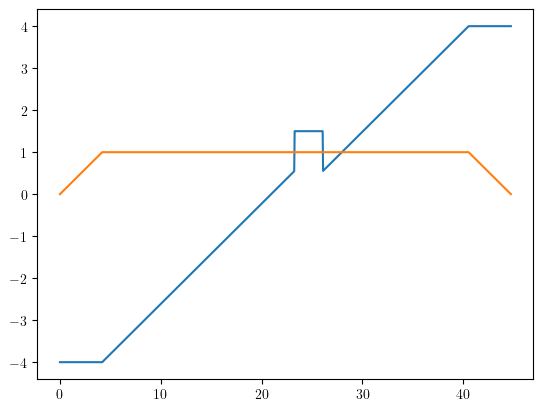

In [4466]:
omega_max=1
delta_i=0.55*omega_max
delta_q=1.5*omega_max
T_q=0.45*2*np.pi/omega_max
delta_min=-4*omega_max
delta_max=4*omega_max

Slope_R=1.5
Slope_R_edge=1.5
R=omega_max**2/(2*np.pi)
Ti=(delta_i-delta_min)/(Slope_R*R)+omega_max/(Slope_R_edge*R)
Tff=(delta_max-delta_i)/(Slope_R*R)+(Ti+T_q)
T_final=Tff+omega_max/(Slope_R_edge*R)

t=np.linspace(0,T_final,1000)
omega,delta=parameter(t,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge)
plt.plot(t,delta)
plt.plot(t,omega)

In [4066]:
parameter(20.1,omega_max,delta_i,delta_q,T_q,delta_min,delta_max)

(1.0, -2.9004928219264516)

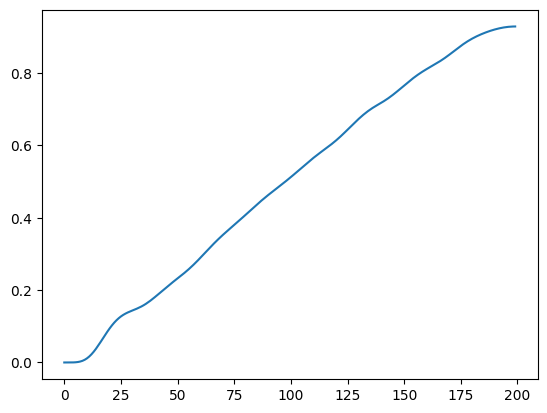

In [2838]:
plt.plot(Entropy)

In [3042]:
import numpy as np
# initialize tensors
d = 2
chi = 55
N=9 # saturates with odd, when single site hamiltonian ignored
A = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

########
A[0,0,0]=-1/np.sqrt(2)
A_edge_L[0,0,0]=-1/np.sqrt(2)
A_edge_R[0,0,0]=-1/np.sqrt(2)
A[0,1,0]=1/np.sqrt(2)
A_edge_L[0,1,0]=1/np.sqrt(2)
A_edge_R[0,1,0]=1/np.sqrt(2)
#########
# A[0,0,0]=1
# A_edge_R[0,0,0]=1
# A_edge_L[0,0,0]=1
#########


MPS=[]
for i in range(N):
    if i==0:
        MPS.append(A_edge_L)
    elif i==N-1:
        MPS.append(A_edge_R)
    else:
        MPS.append(A)

MPS_vid=vidal_form(MPS)

(2, 55)
1.4142134 1.4142135 1.0
(2, 2) (2,) (2, 55)
1.4142135 1.4142135
0.99999994 7.4161983
(55, 2, 1)
0.99999994
check [1.+0.j] [[1.+0.j]]
0.99999994
(110, 1) (1,) (1, 1)
(110, 1)


In [937]:
numiter = 500  # number of timesteps
dt=0.01

# define Hamiltonian (quantum XX model)
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0, -1]])
I=np.array([[1, 0], [0, 1]])
J=1
hL=0.25*J
hT=-0.425*J
ham = (J*np.kron(sZ, sZ) + (hL*(np.kron(sZ, I))+hT*(np.kron(sX, I))))
ham=(ham).reshape(2, 2, 2, 2)
ham_last = (hL*(sZ)+hT*(sX))
ham_last=ham_last.reshape(2, 2)

gate_even = expm(-1 * dt/2 * ham.reshape(d**2, d**2)).reshape(d, d, d, d)
gate_odd = expm(-1 * dt * ham.reshape(d**2, d**2)).reshape(d, d, d, d)
gate_even_last = expm(-1 * dt/2 * ham_last.reshape(d, d)).reshape(d, d)
gate_odd_last = expm(-1 * dt * ham_last.reshape(d, d)).reshape(d, d)

In [938]:
for t in range (numiter):
    MPS_vid=apply_hamiltonian(MPS_vid,gate_even,gate_even_last,"even")
    MPS_vid=apply_hamiltonian(MPS_vid,gate_odd,gate_odd_last,"odd")
    MPS_vid=apply_hamiltonian(MPS_vid,gate_even,gate_even_last,"even")
    rhoAB=get_mid_rho(MPS_vid)
    energyMPS = np.real(ncon([ham, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]))
    # energyMPS = np.real(ncon([MPS_vid[N//2], ham, MPS_vid[N//2]], [[1, 2, 3, 4], [1, 2, 3, 4]]))
    enErr = np.abs(energyMPS - E0)
    print(t*dt,"   ",energyMPS)

0.0     -1.2794791324915833
0.01     -1.2794601460529247
0.02     -1.279444746029068
0.03     -1.2794299595648764
0.04     -1.2794157619912214
0.05     -1.2794021296340539
0.06     -1.2793890397746375
0.07     -1.279376470611314
0.08     -1.279364401222736
0.09     -1.2793528115325465
0.1     -1.279341682275413
0.11     -1.279330994964408
0.12     -1.279320731859656
0.13     -1.279310875938218
0.14     -1.2793014108651706
0.15     -1.2792923209658211
0.16     -1.279283591199029
0.17     -1.2792752071315896
0.18     -1.2792671549136356
0.19     -1.2792594212550208
0.2     -1.2792519934026525
0.21     -1.279244859118723
0.22     -1.279238006659832
0.23     -1.279231424756927
0.24     -1.2792251025960701
0.25     -1.279219029799964
0.26     -1.2792131964102433
0.27     -1.2792075928704594
0.28     -1.2792022100097622
0.29     -1.2791970390272573
0.3     -1.27919207147697
0.31     -1.2791872992534399
0.32     -1.2791827145778927
0.33     -1.2791783099849687
0.34     -1.2791740783100052
0.3

In [936]:
np.real(ncon([rhoAB], [[1, 2, 1, 2]]))

1.0000000000000009

In [3196]:
N=9

In [3197]:
def kronecker_product(matrix_list):
    result = matrix_list[0]
    for matrix in matrix_list[1:]:
        result = np.kron(result, matrix)
    return result
    
rho_site=np.array([[1/2,-1/2],[-1/2,1/2]])
rho=kronecker_product([rho_site for i in range(N)])

In [3198]:
# Generating Hamiltonian

def Parameters(N_):
    # J=np.zeros([N_])
    J=np.ones([N_])
    # J=np.random.uniform(0.1,1.9,N_)
    hL=0.25*np.mean(J)*np.ones([N_])
    # hL=0.9045*np.mean(J)*np.ones([N_])
    # hL=0*J
    hT=-0.425*np.mean(J)*np.ones([N_])
    # hT=1.4*np.mean(J)*np.ones([N_])
    # hT=0*J
    return J,hL,hT

J,hL,hT=Parameters(N)

h=np.zeros([N,2**N,2**N])
Sx=np.zeros([N,2**N,2**N])
Sz=np.zeros([N,2**N,2**N])
Sz_n_Sz_n1=np.zeros([N,2**N,2**N])
Sx_n_Sx_n1=np.zeros([N,2**N,2**N])
Sy_n_Sy_n1=np.zeros([N,2**N,2**N])
Sz_n_Sz_n2=np.zeros([N,2**N,2**N])
I=np.eye(2)
# sx = 1/2*np.array([[0,1],[1,0]])
# sy = 1/2*np.array([[0,-1j],[1j,0]])
# sz = 1/2*np.array([[1,0],[0,-1]])

sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])


I_n=[I for i in range(N)]

for n in range(N):
    chain_=np.copy(I_n)
    chain_[n]=sx
    Sx[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sz
    Sz[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sz
    if n!=N-1:
        chain_[n+1]=sz
    Sz_n_Sz_n1[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sx
    if n!=N-1:
        chain_[n+1]=sx
    Sx_n_Sx_n1[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sy
    if n!=N-1:
        chain_[n+1]=sy
    Sy_n_Sy_n1[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sz
    if n!=N-1 and n!=N-2:
        chain_[n+2]=sz
    Sz_n_Sz_n2[n]=kronecker_product(chain_)


J1=1.1
J2=0.9
h_=0.4
for n in range(N):
    if n==N-1:
        h[n]=-h_*(Sx[n])
    elif n==N-2:
        h[n]=-J1*Sz_n_Sz_n1[n]-h_*(Sx[n])
    else:
        h[n]=-J1*Sz_n_Sz_n1[n]-J2*Sz_n_Sz_n2[n]-h_*(Sx[n])

    # if n==N-1:
    #     h[n]=(Sx[n])
    # else:
    #     h[n]=-J[n]*Sz_n_Sz_n1[n]+(Sx[n])
        

H=np.sum(h,0)

/tmp/ipykernel_93868/3474342549.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  chain_[n]=sy
/tmp/ipykernel_93868/3474342549.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  chain_[n+1]=sy


In [3199]:
eigvals,_=np.linalg.eigh(H)
grd_state_energy=eigvals[0]

In [3200]:
grd_state_energy

-15.331725777838992

In [989]:
eigvals

array([-9., -9., -7., ...,  9., 11., 11.])

In [3289]:
import numpy as np
# initialize tensors
d = 2
chi = 100
# N=14
A = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

######## # spin left
# A[0,0,0]=1/np.sqrt(2)
# A_edge_L[0,0,0]=1/np.sqrt(2)
# A_edge_R[0,0,0]=1/np.sqrt(2)
# A[0,1,0]=-1/np.sqrt(2)
# A_edge_L[0,1,0]=-1/np.sqrt(2)
# A_edge_R[0,1,0]=-1/np.sqrt(2)
######### # spin down
A[0,0,0]=1
A_edge_R[0,0,0]=1
A_edge_L[0,0,0]=1
######### # spin right
# A[0,0,0]=1/np.sqrt(2)
# A_edge_L[0,0,0]=1/np.sqrt(2)
# A_edge_R[0,0,0]=1/np.sqrt(2)
# A[0,1,0]=1/np.sqrt(2)
# A_edge_L[0,1,0]=1/np.sqrt(2)
# A_edge_R[0,1,0]=1/np.sqrt(2)


MPS=[]
for i in range(N):
    if i==0:
        MPS.append(A_edge_L)
    elif i==N-1:
        MPS.append(A_edge_R)
    else:
        MPS.append(A)
MPS[0].shape

MPS_vid=vidal_form(MPS)
MPS_left,SS=left_canonical_form(MPS)

(2, 100)
1.4142135 1.4142135 1.0
(2, 2) (2,) (2, 100)
1.4142135 1.4142135
1.0 10.0
(100, 2, 1)
1.0
check [1.+0.j] [[1.+0.j]]
1.0
(200, 1) (1,) (1, 1)
(200, 1)
(2, 100)
(2, 2) (2,) (2, 100)
(100, 2, 100)
(2, 2, 100) 1.0
(100, 2, 100)
(4, 2, 100) 1.0
(100, 2, 100)
(8, 2, 100) 1.0
(100, 2, 100)
(16, 2, 100) 1.0
(100, 2, 100)
(32, 2, 100) 1.0
(100, 2, 100)
(64, 2, 100) 1.0
(100, 2, 100)
(100, 2, 100) 1.0
(100, 2, 1)
check [1.+0.j] [[1.+0.j]]
(200, 1) (1,) (1, 1)
(200, 1)


In [4857]:
def apply_gate_MPS_left_3(A, B, C, SS, gateABC, stol=1e-7):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""

    SS = SS * (SS > stol) + stol * (SS < stol)
    
    chiA,_,_=A.shape
    _,_,chiB=C.shape
    tensors = [A, B, C, np.diag(SS), gateABC]
    connects = [[-1, 3, 2], [2, 4, 5], [5,6,7], [7,-5], [-2, -3, -4, 3, 4, 6]]
    nshape = [d * chiA, d**2 * chiB]
    utemp, stemp, vhtemp = np.linalg.svd(ncon(tensors, connects).reshape(nshape),full_matrices=False)
    
    # truncate to reduced dimension
    chitemp = min(chi, len(stemp),np.sum(stemp>stol))
    utemp = utemp[:, range(chitemp)].reshape(chiA, d * chitemp)
    vhtemp = vhtemp[range(chitemp), :]
    stemp = stemp[range(chitemp)]/ np.linalg.norm(stemp)

    A = (utemp).reshape(chiA, d, chitemp)
    SS1=stemp

    vhtemp=np.diag(stemp)@vhtemp
    vhtemp=vhtemp.reshape(chitemp*d, d * chiB)

    chitemp_mid=chitemp
    utemp, stemp, vhtemp = np.linalg.svd(vhtemp,full_matrices=False)

    chitemp = min(chi, len(stemp),np.sum(stemp>stol))
    utemp = utemp[:, range(chitemp)].reshape(chitemp_mid, d * chitemp)
    vhtemp = vhtemp[range(chitemp), :]
    stemp = stemp[range(chitemp)]/ np.linalg.norm(stemp)

    B = (utemp).reshape(chitemp_mid, d, chitemp)
    SS2=stemp
    
    vhtemp=ncon([np.diag(stemp),vhtemp.reshape(chitemp,d,chiB),np.diag(1/SS)],[[-1,1],[1,-2,2],[2,-3]])
    
    # remove environment weights to form new MPS tensors A and B
    C = (vhtemp).reshape(chitemp, d, chiB)
    
    return A, SS1, B, SS2, C

def get_TFI_ham_bonds_3(L):

    H_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])

    # for i in range(0,L-1): # -1 to deal the last state separetly
    #     gL=0.5*g
    #     gR=0.5*g
    #     if i == 0: # first bond
    #         gL = g
    #     if i + 1 == L - 1: # last bond
    #         gR = g
    #     H_bond= -J * np.kron(sX, sX) - gL * np.kron(sZ, I) - gR * np.kron(I, sZ)
    #     H_list.append(np.reshape(H_bond, [d, d, d, d]))

    # for i in range(0,L-2):
    #     H_bond = -J * np.kron(sZ, sZ) + g * (np.kron(sX, I))
    #     H_list.append(np.reshape(H_bond, [d, d, d, d]))

    # H_bond = -J * np.kron(sZ, sZ) + g * (np.kron(sX, I) + np.kron(I,sx))
    # H_list.append(np.reshape(H_bond, [d, d, d, d]))

    for i in range(0,L-3):
        H_bond =-J1 * kronecker_product([sZ, sZ, I]) -J2 * kronecker_product([sZ, I, sZ]) - h_ * kronecker_product([sX, I, I])
        H_list.append(np.reshape(H_bond, [d, d, d, d, d, d]))

    H_bond = (-J1 * kronecker_product([sZ, sZ, I]) -J2 * kronecker_product([sZ, I, sZ]) - h_ * kronecker_product([sX, I, I])) + (-J1 * kronecker_product([I, sZ, sZ]) - h_ * kronecker_product([I, sX, I])) + (- h_ * kronecker_product([I, I, sX]))
    H_list.append(np.reshape(H_bond, [d, d, d, d, d, d]))

    H_list2=[]

    for i in range(0,L-2):
        H_bond =-J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])
        H_list2.append(np.reshape(H_bond, [d, d, d, d]))

    H_bond = (-J1 * kronecker_product([sZ, sZ])- h_ * kronecker_product([sX, I]))+ (- h_ * kronecker_product([I, sX]))
    H_list2.append(np.reshape(H_bond, [d, d, d, d]))
    
    return H_list, H_list2
    
def evolve_hamiltonian_3(MPS_left,SS,U_gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    # for iniit in [0,1,0]: # half even/odd/half even
    #     for i in range(iniit,len(MPS_left)-1,2):
    #         A=MPS_left[i]
    #         B=MPS_left[i+1]
    #         A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],U_gates[i],dont_normalize=0)
    #         MPS_left[i]=A
    #         MPS_left[i+1]=B  

    for iniit in [0,1,2,1,0]: # half even/odd/half even
        for i in range(iniit,len(MPS_left)-2,3):
            A=MPS_left[i]
            B=MPS_left[i+1]
            C=MPS_left[i+2]
            A,SS[i],B, SS[i+1], C=apply_gate_MPS_left_3(A,B,C,SS[i+2],U_gates[i])
            MPS_left[i]=A
            MPS_left[i+1]=B 
            MPS_left[i+2]=C
        # MPS_left,SS=Normalized_left(MPS_left,SS)

    # for i in range(0,len(MPS_left)-2):
    #     A=MPS_left[i]
    #     B=MPS_left[i+1]
    #     C=MPS_left[i+2]
    #     A,SS[i],B, SS[i+1],C =apply_gate_MPS_left_3(A,B,C,SS[i+2],U_gates[i])
    #     MPS_left[i]=A
    #     MPS_left[i+1]=B 
    #     MPS_left[i+2]=C

    # for i in range(len(MPS_left)-2-1,-1,-1):
    #     A=MPS_left[i]
    #     B=MPS_left[i+1]
    #     C=MPS_left[i+2]
    #     A,SS[i],B, SS[i+1],C =apply_gate_MPS_left_3(A,B,C,SS[i+2],U_gates[i])
    #     MPS_left[i]=A
    #     MPS_left[i+1]=B 
    #     MPS_left[i+2]=C
    
    return MPS_left, SS

def get_expectations_left_3(MPS_left,SS,gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(0,len(MPS_left)-2):
        A=MPS_left[i]
        B=MPS_left[i+1]
        C=MPS_left[i+2]
        
        expectation=(ncon([A, A.conj(), B, B.conj(), C, C.conj(), np.diag(SS[i+2]**2), gates[i]], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,10,11], [9,13,12], [11,12], [6,8,13,2,4,10]]))
        results.append(expectation)
    return np.array(results)

def Normalized_left(MPS_left,SS):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    gate=kronecker_product([I,I]).reshape(d,d,d,d)
    for i in range(0,len(MPS_left)-1): # -1 to deal the last state separetly
        A=MPS_left[i]
        B=MPS_left[i+1]
        A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],gate)
        MPS_left[i]=A
        MPS_left[i+1]=B    
    
    return MPS_left, SS

In [3750]:
H_bonds,H_bonds2=get_TFI_ham_bonds_3(L=N)
np.sum(get_expectations_left_3(MPS_left,SS,H_bonds))
# np.sum(get_expectations_left(MPS_left,SS,H_bonds2))

(-15.1+0j)

In [3751]:
E0=grd_state_energy
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]
Sx_expect=[]

In [3716]:
U_bonds=[]
for i in range (len(H_bonds)):
    if i%3==0:
        U_bonds.append(expm(-1 * dt/2 * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
    elif i%3==1:
        U_bonds.append(expm(-1 * dt/2 * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
    else:
        U_bonds.append(expm(-1 * dt * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))

In [3717]:
numiter = 100
dt=0.01

for t in range (numiter):
    
    MPS_,SS_=evolve_hamiltonian_3(MPS_,SS_,U_bonds)

    Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
    Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX)[N//2])
    Entropy.append(entagelement_entropy3(SS_)[N//2])
    
    energyMPS=np.sum(get_expectations_left_3(MPS_,SS_,H_bonds))
    energyMPS2=np.sum(get_expectations_left(MPS_,SS_,H_bonds2))
    Energy.append(energyMPS2)
    
    print(t*dt,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/E0)#,fidelity2(MPS_,MPS__))

0.0     0.9999999999995044 (-15.126954618267757+0j) (-0.013356041096640191-0j)
0.01     0.9999999999947138 (-15.15054602512242+0j) (-0.011817309762900628-0j)
0.02     0.9999999999650134 (-15.17121493187884+0j) (-0.010469196246136885-0j)
0.03     0.9999999998999318 (-15.18934288773626+0j) (-0.009286814293831004-0j)
0.04     0.9999999997878254 (-15.205260164244752+0j) (-0.008248622198620178-0j)
0.05     0.9999999996212229 (-15.219252649717111+0j) (-0.007335973115593632-0j)
0.06     0.9999999993968248 (-15.231567857854351+0j) (-0.0065327231543243795-0j)
0.07     0.999999999114991 (-15.242420147640031+0j) (-0.0058248909152840735-0j)
0.08     0.9999999987789493 (-15.251995246910242+0j) (-0.0052003624434761786-0j)
0.09     0.9999999983939827 (-15.260454165021825+0j) (-0.004648636027666602-0j)
0.1     0.9999999979666924 (-15.267936572202798+0j) (-0.004160601784855642-0j)
0.11     0.9999999975043524 (-15.274563715124746+0j) (-0.0037283514943158066-0j)
0.12     0.9999999970144362 (-15.280440930

In [3314]:
MPS___=MPS_.copy()

In [3757]:
energyMPS2

(-9.126504271436682+0j)

In [3752]:
get_expectations_left_3(MPS_,SS_,H_bonds)

array([-2. +0.j, -2. +0.j, -2. +0.j, -2. +0.j, -2. +0.j, -2. +0.j,
       -3.1+0.j])

In [4863]:
# def get_TFI_ham_bonds_3(L,dt,t):

#     omega,delta=parameter(t,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge)

#     H_list=[]

#     sX = np.array([[0, 1.], [1., 0]])
#     sY = np.array([[0, -1j], [1j, 0]])
#     sZ = np.array([[1., 0], [0, -1.]])
#     I=np.array([[1., 0.], [0., 1.]])
#     P=I-nZ

#     for i in range(0,L-3):
#         if i==0:
#             H_bond =omega/2* kronecker_product([P, sX, P]) + omega/2* kronecker_product([sX, P, I]) 
#         else:
#             H_bond =omega/2 * kronecker_product([P, sX, P]) 
#         H_list.append(np.reshape(H_bond, [d, d, d, d, d, d]))

#     H_bond = omega/2* kronecker_product([P, sX, P]) + omega/2* kronecker_product([I, sX, P])
#     H_list.append(np.reshape(H_bond, [d, d, d, d, d, d]))

#     H_bonds=H_list

#     U_bonds=[]
#     for i in range (len(H_bonds)):
#         if i%3==0:
#             U_bonds.append(expm(-1j * dt/2 * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
#         elif i%3==1:
#             U_bonds.append(expm(-1j * dt/2 * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
#         else:
#             U_bonds.append(expm(-1j * dt * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
    
#     return H_list, U_bonds

In [4864]:
# MPS_=MPS_left.copy()
# SS_=SS.copy()
# # Energy=[]
# # Entropy=[]
# # Sz_expect=[]
# # Sx_expect=[]
# # Nz_expect=[]
# # Prob_Z=[]
# # Prob_Z1=[]
# # Prob_Z2=[]
# # Prob_S=[]
# # Prob_S2=[]

In [4867]:
# numiter = 1000
# dt=T_final/numiter
# print(dt)

# for t in np.arange(0,T_final,dt):

#     _,U_bonds=get_TFI_ham_bonds_3(N,dt,t=t)
    
#     MPS_,SS_=evolve_hamiltonian_3(MPS_,SS_,U_bonds)

#     # Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
#     # Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX)[N//2])
#     # Entropy.append(entagelement_entropy3(SS_)[N//2])
    
#     # energyMPS=np.sum(get_expectations_left_3(MPS_,SS_,H_bonds))
#     # energyMPS2=np.sum(get_expectations_left(MPS_,SS_,H_bonds2))
#     # Energy.append(energyMPS2)
    
#     print(t/dt)#,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/E0)#,fidelity2(MPS_,MPS__))

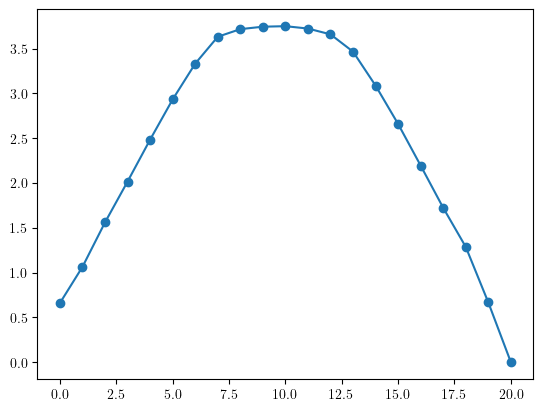

In [4866]:
plt.plot(entagelement_entropy3(SS_),'o-')

In [3210]:
P=[]
for i in range (N-1):
    P_=[]
    for j in range(i+1,i+3):
        if j<N:
            P_.append((i,j))
    P.append(P_)

In [3111]:
P_=list(reversed(P))

In [3770]:
P

[[(0, 1), (0, 2)],
 [(1, 2), (1, 3)],
 [(2, 3), (2, 4)],
 [(3, 4), (3, 5)],
 [(4, 5), (4, 6)],
 [(5, 6), (5, 7)],
 [(6, 7), (6, 8)],
 [(7, 8)]]

In [3211]:
P_rev=[]
P_=list(reversed(P))
for i in range(len(P)):
    P_rev.append(list(reversed(P_[i])))

In [4159]:
def get_Ham(P,dt=1e-1):

    def get_hamill(i,j):
        if i==N-2 and j==N-1:
            return (-J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])) + ( - h_ * kronecker_product([I, sX]) )
        if j==i+1:
            return -J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])
        elif j==i+2:
            return -J2 * kronecker_product([sZ, sZ])
            
    
    H_list=[]
    U_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])

    for i in range(len(P)):
        H_=[]
        U_=[]
        for j in range(len(P[i])):
            k,l=P[i][j]
            H_bond=get_hamill(k,l)
            H_bond=np.reshape(H_bond, [d, d, d, d])
            U_.append(expm(-1j * dt * H_bond.reshape(d**2, d**2)).reshape(d, d, d, d))
            H_.append(H_bond)
        H_list.append(H_)
        U_list.append(U_)
    
    return H_list, U_list

def evolve_hamiltonian_chain(MPS_left,SS,P,U_gates,P_rev,U_gates_rev):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    for i in range(len(P)):
        for j in range(len(P[i])):
            k,l=P[i][j]
            # print((k,l))
            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            A,SS[l-1],B=apply_gate_MPS_left(A,B,SS[l],U_gates[i][j])
            MPS_left[l-1]=A
            MPS_left[l]=B 
        # print('going back')
        for j in range(len(P[i])-1,0,-1):
            k,l=P[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
    # print("fed")

    # print(len(P_rev))
    for i in range(len(P_rev)):
        
        for j in range(len(P_rev[i])-1-1,-1,-1):#range(0,len(P_rev[i])-1):
            k,l=P_rev[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
            
        for j in range(len(P_rev[i])):
            k,l=P_rev[i][j]
            # print((k,l))
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            A,SS[l-1],B=apply_gate_MPS_left(A,B,SS[l],U_gates_rev[i][j])
            MPS_left[l-1]=A
            MPS_left[l]=B 

            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
        # print('going back')   
    
    
    return MPS_left, SS

def energy_chain(MPS_left,SS,P,gates,P_rev,U_gates_rev,dont_normalize=0):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    
    results=[]
    for i in range(0,len(MPS_left)-2):
        # print(i,i+1,i+2)
        A=MPS_left[i]
        B=MPS_left[i+1]
        C=MPS_left[i+2]

        gateAB=gates[i][0]
        gateAC=gates[i][1]

        # gateABC=ncon([gateAB,gateAC],[[1,-2,-4,-5],[-1,-3,1,-6]])
        # gateABC=ncon([gateAC,gateAB],[[-1,-2,1,-5],[1,-3,-4,-6]])

        SS_B=SS[i+1]
        # SS_C=SS[i+2]

        # A,SS_A,B=apply_gate_MPS_left(A,B,SS_B,gateAB)

        # A,SS_A,B=apply_gate_MPS_left(A,B,SS_B,Swap)        
        
        # B,SS_B,C=apply_gate_MPS_left(B,C,SS_C,gateAC)

        # A,SS_A,B=apply_gate_MPS_left(A,B,SS_B,Swap)        

        # expectation=(ncon([A, MPS_left[i].conj(), B, MPS_left[i+1].conj(), C, MPS_left[i+2].conj(), np.diag(SS[i+2]**2)], [[1, 2, 3], [1, 2, 9], [3,4,5], [9,4,10], [5,6,7], [10,6,11], [7,11]]))
        
        
        # expectation=(ncon([A, A.conj(), B, B.conj(), C, C.conj(), np.diag(SS[i+2]**2), gates[i], gates[i+1]], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,10,11], [9,13,12], [11,12], [6,14,2,4], [8,13,14,10]]))
        # expectation=(ncon([A, A.conj(), B, B.conj(), C, C.conj(), np.diag(SS[i+2]**2), gateABC], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,10,11], [9,13,12], [11,12], [6,8,13,2,4,10]]))
        
        
        
        expectation=(ncon([A, A.conj(), B, B.conj(), np.diag(SS[i+1]**2), gateAB], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))
        A,SS_A,B=apply_gate_MPS_left(A,B,SS_B,Swap)
        expectation+=(ncon([B, B.conj(), C, C.conj(), np.diag(SS[i+2]**2), gateAC], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))

        # A,SS_A,B=apply_gate_MPS_left(A,B,SS_B,Swap)
        # expectation=(ncon([B, B.conj(), C, C.conj(), np.diag(SS[i+2]**2), gateAC], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))
        # A,SS_A,B=apply_gate_MPS_left(A,B,SS_B,Swap)
        # expectation+=(ncon([A, A.conj(), B, B.conj(), np.diag(SS[i+1]**2), gateAB], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))
        
        
        results.append(expectation)

    A=MPS_left[-2]
    B=MPS_left[-1]
    gateAB=gates[-1][0]
    expectation=(ncon([A, A.conj(), B, B.conj(), np.diag(SS[-1]**2), gateAB], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))
    results.append(expectation)
    
    return np.array(results)

def energy_chain1(MPS_left,SS,P,gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(len(P)):
        for j in range(len(P[i])):
            k,l=P[i][j]
            # print((k,l))
            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            expectation=(ncon([A, A.conj(), B, B.conj(), np.diag(SS[l]**2), gates[i][j]], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))
            results.append(expectation)
            
        # print('going back')
        for j in range(len(P[i])-1,0,-1):
            k,l=P[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
    # print("fed")    
    
    return results

In [4160]:
P_nn=[[(i,i+1) for i in range(N-1)]]
H_nn,_=get_Ham(P_nn)
H_nn=H_nn[0]

In [4161]:
P=[]
for i in range (N-1):
    P_=[]
    for j in range(i+1,i+3):
        if j<N:
            P_.append((i,j))
    P.append(P_)

P_rev=[]
P_=list(reversed(P))
for i in range(len(P)):
    P_rev.append(list(reversed(P_[i])))

In [4162]:
E0=grd_state_energy
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]
Sx_expect=[]

In [4163]:
numiter = 100
dt=0.01

H_bonds,U_bonds=get_Ham(P,dt/2)
H_bonds_rev,U_bonds_rev=get_Ham(P_rev,dt/2)

for t in range (numiter):
    
    MPS_,SS_=evolve_hamiltonian_chain(MPS_,SS_,P,U_bonds,P_rev,U_bonds_rev)

    Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
    Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX)[N//2])
    Entropy.append(entagelement_entropy3(SS_)[N//2])

    # print("agberge")

    
    energyMPS=np.sum(get_expectations_left(MPS_,SS_,H_nn))
    Energy.append(energyMPS)
    energyMPS=np.sum(energy_chain1(MPS_,SS_,P,H_bonds))
    
    print(t*dt,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/E0)

0.0     1.0000000000000016 (-17.099999857527177-2.775626382989856e-17j) (0.11533431430427157+1.810380920719207e-18j)
0.01     1.000000000000002 (-17.099999431058873-1.0884246317275671e-16j) (0.11533428648820504+7.099165791895482e-18j)
0.02     1.0000000000000002 (-17.099998723439413-8.470329472543003e-19j) (0.11533424033427103+5.524707130352091e-20j)
0.03     1.000000000000001 (-17.0999977393855+1.1275024967491443e-16j) (0.11533417615011288-7.354048155354275e-18j)
0.04     1.0000000000000013 (-17.099996485449818-5.2814198327200135e-17j) (0.11533409436312421+3.4447653899171356e-18j)
0.05     1.0000000000000016 (-17.09999496997148-5.5402731014009277e-17j) (0.11533399551721733+3.613600439820695e-18j)
0.06     1.0000000000000013 (-17.099993203012655-2.22573153484118e-16j) (0.11533388026868954+1.451716243228358e-17j)
0.07     1.0000000000000022 (-17.0999911962827+7.906544342850541e-17j) (0.11533374938127458-5.156982623755856e-18j)
0.08     1.0000000000000007 (-17.09998896304974-6.8846837952

In [4120]:
def get_Ham(P,dt=1e-1):

    def get_hamill(i,j):
        if i==N-2 and j==N-1:
            return (-J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])) + ( - h_ * kronecker_product([I, sX]) )
        if j==i+1:
            return -J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])
        elif j==i+2:
            return -J2 * kronecker_product([sZ, sZ])
        else:
            return kronecker_product([I*0.0, I*0.0])
            
    
    H_list=[]
    U_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])

    for i in range(len(P)):
        H_=[]
        U_=[]
        for j in range(len(P[i])):
            k,l=P[i][j]
            H_bond=get_hamill(k,l)
            H_bond=np.reshape(H_bond, [d, d, d, d])
            U_.append(expm(-1j * dt * H_bond.reshape(d**2, d**2)).reshape(d, d, d, d))
            H_.append(H_bond)
        H_list.append(H_)
        U_list.append(U_)
    
    return H_list, U_list

In [4121]:
P_nn=[[(i,i+1) for i in range(N-1)]]
H_nn,_=get_Ham(P_nn)
H_nn=H_nn[0]

In [4122]:
P=[]
for i in range (N-1):
    P_=[]
    for j in range(i+1,i+4):
        if j<N:
            P_.append((i,j))
    P.append(P_)

P_rev=[]
P_=list(reversed(P))
for i in range(len(P)):
    P_rev.append(list(reversed(P_[i])))
P_rev

[[(8, 9)],
 [(7, 9), (7, 8)],
 [(6, 9), (6, 8), (6, 7)],
 [(5, 8), (5, 7), (5, 6)],
 [(4, 7), (4, 6), (4, 5)],
 [(3, 6), (3, 5), (3, 4)],
 [(2, 5), (2, 4), (2, 3)],
 [(1, 4), (1, 3), (1, 2)],
 [(0, 3), (0, 2), (0, 1)]]

In [4123]:
E0=grd_state_energy
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]
Sx_expect=[]

In [4124]:
numiter = 100
dt=0.01

H_bonds,U_bonds=get_Ham(P,dt/2)
H_bonds_rev,U_bonds_rev=get_Ham(P_rev,dt/2)

for t in range (numiter):
    
    MPS_,SS_=evolve_hamiltonian_chain(MPS_,SS_,P,U_bonds,P_rev,U_bonds_rev)

    Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
    Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX)[N//2])
    Entropy.append(entagelement_entropy3(SS_)[N//2])

    # print("agberge")

    
    # energyMPS=np.sum(energy_chain(MPS_,SS_,P,H_bonds,[],[]))
    energyMPS=np.sum(get_expectations_left(MPS_,SS_,H_nn))
    Energy.append(energyMPS)
    energyMPS=np.sum(energy_chain1(MPS_,SS_,P,H_bonds))
    
    print(t*dt,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/E0)

0.0     1.0000000000000013 (-17.09999985752718-4.341573250270323e-19j) (0.11533431430427181+2.8317576985010934e-20j)
0.01     1.000000000000002 (-17.099999431058876-4.391865831513547e-19j) (0.11533428648820528+2.864560647087559e-20j)
0.02     1.0000000000000007 (-17.09999872343942-1.665368418255625e-16j) (0.11533424033427149+1.0862237183127853e-17j)
0.03     1.0000000000000002 (-17.099997739385504+1.127468615431254e-16j) (0.1153341761501131-7.353827167069062e-18j)
0.04     1.0000000000000018 (-17.09999648544983-7.860465750519907e-19j) (0.1153340943631249+5.1269282169667405e-20j)
0.05     1.0000000000000018 (-17.09999496997151-2.254869468226728e-16j) (0.11533399551721943+1.4707212357567693e-17j)
0.06     0.9999999999999996 (-17.099993203012737-1.043544591017298e-18j) (0.11533388026869487+6.806439184593776e-20j)
0.07     1.0000000000000009 (-17.09999119628301+2.7538735181131813e-17j) (0.11533374938129475-1.7961927822200717e-18j)
0.08     0.9999999999999997 (-17.099988963050954-2.13587827

In [4803]:
N=22
d = 2
chi = 50
A = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A[0,0,0]=1
A_edge_R[0,0,0]=1
A_edge_L[0,0,0]=1


MPS=[]
for i in range(N):
    if i==0:
        MPS.append(A_edge_L)
    elif i==N-1:
        MPS.append(A_edge_R)
    else:
        MPS.append(A)
MPS[0].shape

MPS_left,SS=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [4804]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
A_even1 = np.zeros([chi, d, chi], dtype=np.complex64)
A_even2 = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

A_even1[0,0,0]=1
A_even2[0,1,0]=1

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_odd)
    if i!=(N)//3-1-1:
        MPS.append(A_even1)
        MPS.append(A_even2)


MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_Z1,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [4805]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
A_even1 = np.zeros([chi, d, chi], dtype=np.complex64)
A_even2 = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

A_even1[0,1,0]=1 # changed
A_even2[0,0,0]=1 # changed

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_odd)
    if i!=(N)//3-1-1:
        MPS.append(A_even1)
        MPS.append(A_even2)


MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_Z2,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [4806]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
A_even1 = np.zeros([chi, d, chi], dtype=np.complex64)
A_even2 = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

A_even1[0,0,0]=1/np.sqrt(2)
A_even1[0,1,0]=1/np.sqrt(2)
A_even2[0,0,0]=1/np.sqrt(2)
A_even2[0,1,0]=1/np.sqrt(2)

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_odd)
    if i!=(N)//3-1-1:
        MPS.append(A_even1)
        MPS.append(A_even2)


MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_Z,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [4807]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
Ao = np.zeros([chi, d, chi], dtype=np.complex64)
Ae = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

Ae[0,0,0]=0
Ae[0,0,1]=1/np.sqrt(2)
Ae[0,1,0]=1/np.sqrt(2)
Ae[0,1,1]=0

Ao[0,0,0]=1
Ao[1,0,0]=0
Ao[0,1,0]=0
Ao[1,1,0]=1

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_odd)
    if i!=(N)//3-1-1:
        MPS.append(Ae)
        MPS.append(Ao)

# MPS=[Ao if i%2!=0 else Ae for i in range (N)]



MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_S,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [4808]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
A_exc = np.zeros([chi, d, chi], dtype=np.complex64)
A_even1 = np.zeros([chi, d, chi], dtype=np.complex64)
A_even2 = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1
A_exc[0,1,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

A_even1[0,0,0]=1
A_even2[0,0,0]=1

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_exc)
    if i!=(N)//3-1-1:
        MPS.append(A_even1)
        MPS.append(A_even2)


MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_S2,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [4881]:
def get_Ham_Ryd(P,t,dt=1e-1):

    omega,delta=parameter(t,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge)

    Vnn=12.5*omega_max
    Vh=0.4*omega_max
    Vd=Vh/2.0
    # only 0.4 and 0.2 work for now. 0.35 and /2.37 doesnt work

    # WRONGGG; works but the probabilities are lower
    ## double to convert sum over all pair into forward count only
    # Vnn=2.0*Vnn
    # Vh=2.0*Vh
    # Vd=2.0*Vd

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])
    nZ=-0.5*(sZ-I)

    def get_hamill(i,j):      
        if i==N-2 and j==N-1: # last bond: i in bottion
            return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ])) + (omega/2 * kronecker_product([I, sX]) - delta * kronecker_product([I, nZ]))
        if j==i+1:
            return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ]))
        top=[q+1 for q in range(0,N-1,3)]
        middle=[q for q in range(0,N-1,3)]
        bottom=[q+2 for q in range(0,N-1,3)]
        if i in middle:
            # if j==i+1:
            #     return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ]))
            if j==i+2:
                return (Vnn * kronecker_product([nZ, nZ]))
            elif j==i+3:
                return (Vh * kronecker_product([nZ, nZ]))
        if i in top:
            # if j==i+1:
            #     return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ]))
            if j==i+2:
                return (Vnn * kronecker_product([nZ, nZ]))
            elif j==i+3:
                return (Vh * kronecker_product([nZ, nZ]))
            elif j==i+4:
                return (Vd * kronecker_product([nZ, nZ]))
        if i in bottom:
            # if j==i+1:
            #     return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ]))
            if j==i+2:
                return (Vd * kronecker_product([nZ, nZ]))
            elif j==i+3:
                return (Vh * kronecker_product([nZ, nZ]))            
    
    H_list=[]
    U_list=[]

    for i in range(len(P)):
        H_=[]
        U_=[]
        for j in range(len(P[i])):
            k,l=P[i][j]
            H_bond=get_hamill(k,l)
            H_bond=np.reshape(H_bond, [d, d, d, d])
            U_.append(expm(-1j * dt * H_bond.reshape(d**2, d**2)).reshape(d, d, d, d))
            H_.append(H_bond)
        H_list.append(H_)
        U_list.append(U_)
    
    return H_list, U_list

def evolve_hamiltonian_chain_Ryd(MPS_left,SS,P,P_rev,t,dt):
    MPS_left=MPS_left.copy()
    SS=SS.copy()

    # _,U_gates=get_Ham_Ryd(P,t,dt/2)
    # _,U_gates_rev=get_Ham_Ryd(P_rev,t,dt/2)

    _,U_gates=get_Ham_Ryd(P,t,dt)
    P_rev=[]
    
    for i in range(len(P)):
        for j in range(len(P[i])):
            k,l=P[i][j]
            # print((k,l))
            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            A,SS[l-1],B=apply_gate_MPS_left(A,B,SS[l],U_gates[i][j])
            MPS_left[l-1]=A
            MPS_left[l]=B 
        # print('going back')
        for j in range(len(P[i])-1,0,-1):
            k,l=P[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
    # print("fed")

    # print(len(P_rev))
    for i in range(len(P_rev)):
        
        for j in range(len(P_rev[i])-1-1,-1,-1):#range(0,len(P_rev[i])-1):
            k,l=P_rev[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
            
        for j in range(len(P_rev[i])):
            k,l=P_rev[i][j]
            # print((k,l))
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            A,SS[l-1],B=apply_gate_MPS_left(A,B,SS[l],U_gates_rev[i][j])
            MPS_left[l-1]=A
            MPS_left[l]=B 

            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
        # print('going back')   
    
    
    return MPS_left, SS

0.1033583983031042

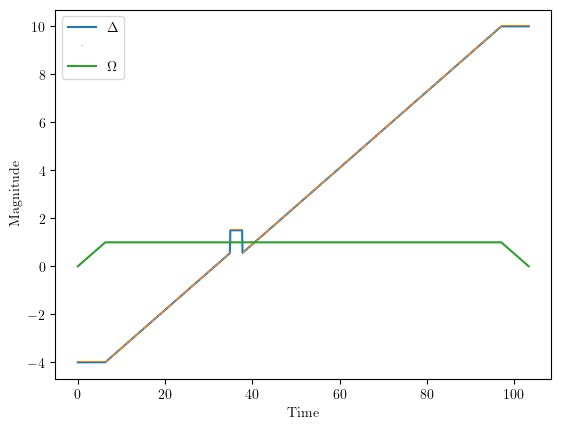

In [4882]:
omega_max=1
delta_i=0.55*omega_max
delta_q=1.5*omega_max
T_q=0.45*2*np.pi/omega_max
delta_min=-4*omega_max
delta_max=10*omega_max

Slope_R=1
Slope_R_edge=1
R=omega_max**2/(2*np.pi)
Ti=(delta_i-delta_min)/(Slope_R*R)+omega_max/(Slope_R_edge*R)
Tff=(delta_max-delta_i)/(Slope_R*R)+(Ti+T_q)
T_final=Tff+omega_max/(Slope_R_edge*R)

t=np.linspace(0,T_final,1000)
omega,delta=parameter(t,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge)
plt.plot(t,delta,',-')
plt.plot(t,delta,',')
plt.plot(t,omega)
plt.legend([r"$\Delta$",None,r"$\Omega$"])
plt.xlabel("Time")
plt.ylabel("Magnitude")

numiter = 1000
dt=T_final/numiter
dt

In [4883]:
P=[]
top=[q+1 for q in range(0,N,3)]
middle=[q for q in range(0,N,3)]
bottom=[q+2 for q in range(0,N,3)]
if N-1 not in middle:
    raise Exception("ERRROOOR")
for i in range (N-1):
    P_=[]
    if i in top:
        i_final=i+1+4
    elif i in middle:
        i_final=i+1+3
    else:
        i_final=i+1+3
    for j in range(i+1,i_final):
        if j<N:
            P_.append((i,j))
    P.append(P_)

P_rev=[]
P_=list(reversed(P))
for i in range(len(P)):
    P_rev.append(list(reversed(P_[i])))
P

[[(0, 1), (0, 2), (0, 3)],
 [(1, 2), (1, 3), (1, 4), (1, 5)],
 [(2, 3), (2, 4), (2, 5)],
 [(3, 4), (3, 5), (3, 6)],
 [(4, 5), (4, 6), (4, 7), (4, 8)],
 [(5, 6), (5, 7), (5, 8)],
 [(6, 7), (6, 8), (6, 9)],
 [(7, 8), (7, 9), (7, 10), (7, 11)],
 [(8, 9), (8, 10), (8, 11)],
 [(9, 10), (9, 11), (9, 12)],
 [(10, 11), (10, 12), (10, 13), (10, 14)],
 [(11, 12), (11, 13), (11, 14)],
 [(12, 13), (12, 14), (12, 15)],
 [(13, 14), (13, 15), (13, 16), (13, 17)],
 [(14, 15), (14, 16), (14, 17)],
 [(15, 16), (15, 17), (15, 18)],
 [(16, 17), (16, 18), (16, 19), (16, 20)],
 [(17, 18), (17, 19), (17, 20)],
 [(18, 19), (18, 20), (18, 21)],
 [(19, 20), (19, 21)],
 [(20, 21)]]

In [4884]:
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]
Sx_expect=[]
Nz_expect=[]
Prob_Z=[]
Prob_Z1=[]
Prob_Z2=[]
Prob_S=[]
Prob_S2=[]

In [4885]:
numiter = 1000
dt=T_final/numiter
print(dt)

for t in np.arange(0,T_final,dt):
    
    MPS_,SS_=evolve_hamiltonian_chain_Ryd(MPS_,SS_,P,P_rev,t,dt)

    Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ))
    Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX))
    Nz_expect.append(apply_single_operator_left(MPS_,SS_,nZ))
    Entropy.append(entagelement_entropy3(SS_))
    Prob_Z.append(fidelity2(MPS_,MPS_Z))
    Prob_Z1.append(fidelity2(MPS_,MPS_Z1))
    Prob_Z2.append(fidelity2(MPS_,MPS_Z2))
    Prob_S.append(fidelity2(MPS_,MPS_S))
    Prob_S2.append(fidelity2(MPS_,MPS_S2))

    # energyMPS=np.sum(get_expectations_left(MPS_,SS_,H_nn))
    # Energy.append(energyMPS)
    # energyMPS=np.sum(energy_chain1(MPS_,SS_,P,H_bonds))
    
    print(int(t/dt),"   ",fidelity2(MPS_,MPS_))

0.1033583983031042
0     (1+1.7805440665382967e-54j)
1     (1.0000000000000007-3.1763735522036263e-22j)
2     (0.9999999999999938+4.235164736271502e-22j)
2     (1-5.082197683525802e-21j)
4     (0.999999999999998+0j)
5     (0.9999999999999957+0j)
5     (0.9999999999999962-6.776263578034403e-20j)
7     (1.0000000000000004+5.421010862427522e-20j)
8     (0.9999999999999988+2.710505431213761e-20j)
9     (1+4.87890977618477e-19j)
10     (1.0000000000000004+0j)
11     (0.9999999999999988-1.3552527156068805e-19j)
11     (1.0000000000000018+2.303929616531697e-19j)
13     (0.9999999999999989+4.336808689942018e-19j)
14     (0.9999999999999949+4.342102645862357e-19j)
15     (0.9999999999999991-9.762054717105811e-19j)
16     (1.000000000000001+1.7381116077658243e-18j)
17     (0.9999999999999984+7.291259609965017e-18j)
18     (1.0000000000000009+8.673617379884035e-19j)
19     (1.0000000000000007+6.749158523722265e-18j)
20     (1.0000000000000004+5.421010862427522e-20j)
20     (0.9999999999999994+1.5

(0.0, 5.0)

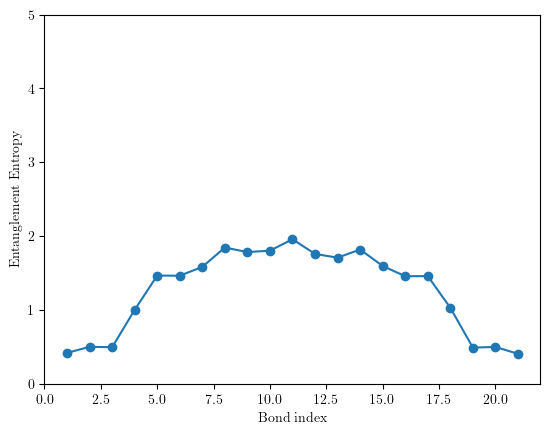

In [4886]:
Bond_idx=range(1,N)
plt.plot(Bond_idx,Entropy[-1],'o-')
plt.xlabel("Bond index")
plt.ylabel("Entanglement Entropy")
plt.ylim([0,5])

/home/zilch/anaconda3/envs/torch/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/zilch/anaconda3/envs/torch/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Fidelity')

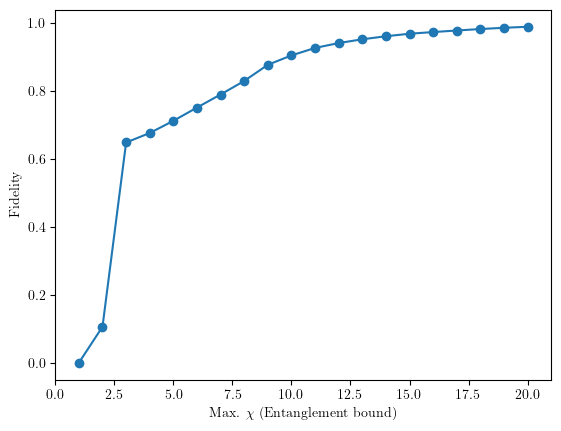

In [4890]:
chi_main=chi
MPS_main=MPS_.copy()
SS_main=SS_.copy()
max_chi=[]
Fidelity=[]
max_=21
for i in range(1,max_,1):
    chi=int(i)
    max_chi.append(chi)
    # MPS__temp,_=Normalized_left(MPS_main,SS_main)
    Fidelity.append(fidelity_truncate(MPS_main,chi))
chi=chi_main

plt.plot(max_chi,Fidelity,'o-')
plt.xlim([0,max_])
plt.xlabel(r"Max. $ \chi $ (Entanglement bound)")
plt.ylabel("Fidelity")

In [4889]:
def fidelity_truncate(MPS_B,chi_trun):
    
    MPS_B=MPS_B.copy()

    for i in range(len(MPS_B)):
        B=MPS_B[i]
        chi_L,_,chi_R=B.shape
        B=B.reshape(chi_L*d,chi_R)
        chi_R=min(chi_R,chi_trun)
        B=B[:,range(chi_R)]
        B=B.reshape(chi_L,chi_R*d)
        chi_L=min(chi_L,chi_trun)
        B=B[range(chi_L),:]
        B=B.reshape(chi_L,d,chi_R)
        MPS_B[i]=B
        # print()

    
    MPS_A=MPS_B.copy()
    for i in range(len(MPS_B)):
        MPS_B[i]=np.conj(MPS_B[i])    
        
        
        
    Norm=ncon([MPS_A[0],MPS_B[0]],[[1,2,-1],[1,2,-2]])
    for i in range(1,len(MPS_A)):
        Norm=ncon([Norm,MPS_A[i],MPS_B[i]],[[1,3],[1,2,-1],[3,2,-2]])
    return (ncon([Norm],[[1,1]]))

In [4240]:
MPS___=MPS_.copy()
SS___=SS_.copy()

In [4184]:
MPS_=MPS___.copy()
SS_=SS___.copy()

In [4138]:
MPS_=Us.copy()
SS_=SS.copy()

Text(0.5, 1.0, 'Sweep-quench-sweep')

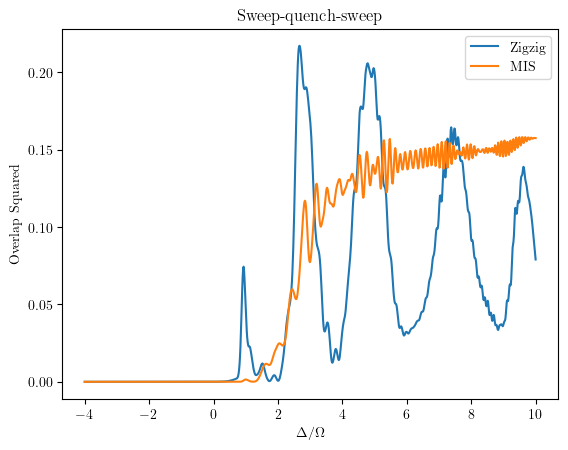

In [4897]:
x_=np.linspace(delta_min/omega_max, delta_max/omega_max,len(Prob_S))
plt.plot(x_,(np.abs(np.array(Prob_S)))**2)
plt.plot(x_,(np.abs(np.array(Prob_S2)))**2)
# plt.plot((np.array(Prob_Z))**2)
# plt.plot((np.array(Prob_Z1))**2)
# plt.plot((np.array(Prob_Z2))**2)
plt.xlabel(r"$\Delta / \Omega$")
plt.ylabel("Overlap Squared")
plt.legend(["Zigzig","MIS"])
plt.title("Sweep-quench-sweep")
# plt.title("Sweep")

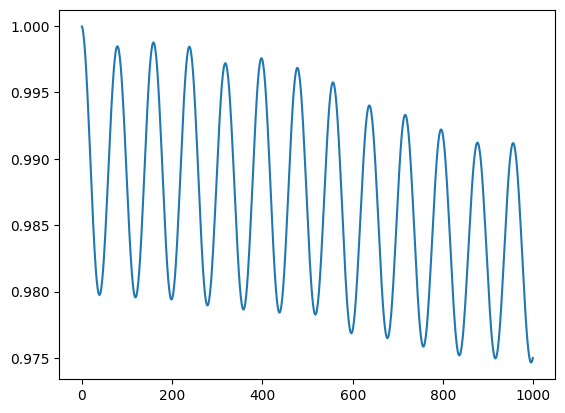

In [3992]:
plt.plot(Sz_expect)

In [4760]:
Nz_=[]
for i in range(len(Nz_expect)):
    Nz__=[]
    for j in range(0,N-1,3):
        Nz__.append(np.real(Nz_expect[i][j]))
        Nz__.append(np.real(Nz_expect[i][j+1]+Nz_expect[i][j+2]))
    Nz__.append(np.real(Nz_expect[i][-1]))
    Nz_.append(Nz__)
Nz_=np.array(Nz_)

In [4596]:
del_omeg=delta/omega_max
np.max(del_omeg[np.isfinite(del_omeg)])

np.where(omega<omega_max)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57, 942, 943, 944, 945, 946, 947, 948,
        949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961,
        962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974,
        975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987,
        988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]),)

In [4567]:
N-4

12

Text(0.5, 1.0, 'Sweep-quench-sweep')

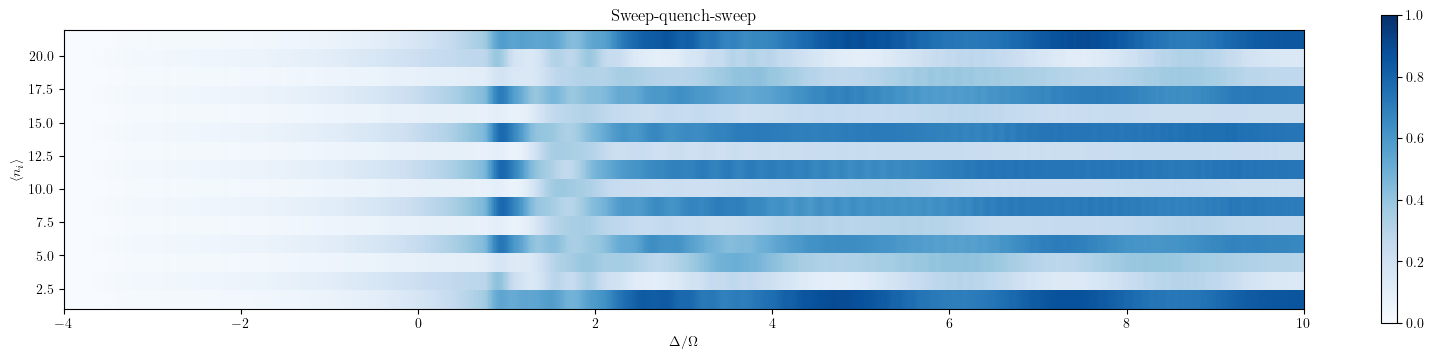

In [4823]:
plt.figure(figsize = (20,4))
plt.imshow(np.real(Nz_).T, interpolation='none',  extent = [delta_min/omega_max, delta_max/omega_max, 1, N], aspect = 0.15, vmin=0, vmax=1, cmap='Blues')
plt.colorbar()
# y__ = np.array(range(1,N-4)) # the grid to which your data corresponds
# ny = y__.shape[0]
# no_labels = len(y__)#int(len(T_)/2) # how many labels to see on axis x
# step_y = 2*(ny / (no_labels)) # step between consecutive labels
# y_positions = np.arange(0+step_y,ny-step_y/2,step_y) # pixel count at label position
# y_labels = y__#[::step_y] # labels you want to see
# y_labels = [int(y_labels[i]) for i in range(len(y_labels))]
# plt.yticks(y_positions, y_labels)

plt.xlabel(r"$\Delta / \Omega$")
plt.ylabel(r"$ \langle n_i \rangle $")
plt.title("Sweep-quench-sweep")
# plt.title("Sweep")

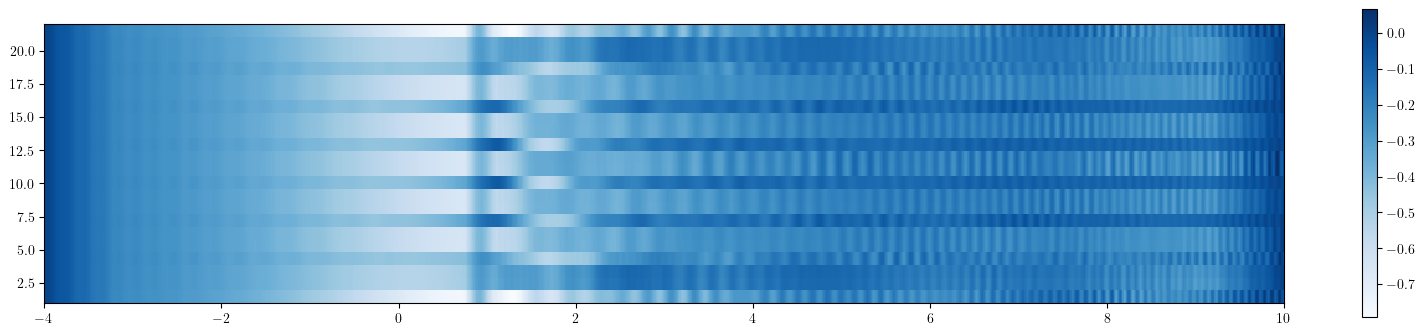

In [4824]:
plt.figure(figsize = (20,4))
plt.imshow(np.real(Sx_expect).T, interpolation='none',  extent = [delta_min/omega_max, delta_max/omega_max, 1, N], aspect = 0.15, cmap='Blues')
plt.colorbar()

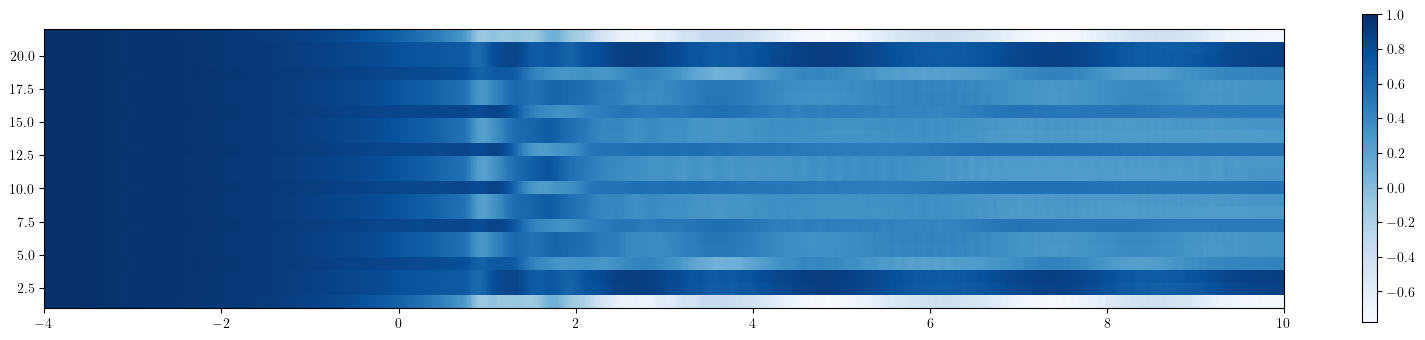

In [4825]:
plt.figure(figsize = (20,4))
plt.imshow(np.real(Sz_expect).T, interpolation='none',  extent = [delta_min/omega_max, delta_max/omega_max, 1, N], aspect = 0.15, cmap='Blues')
plt.colorbar()

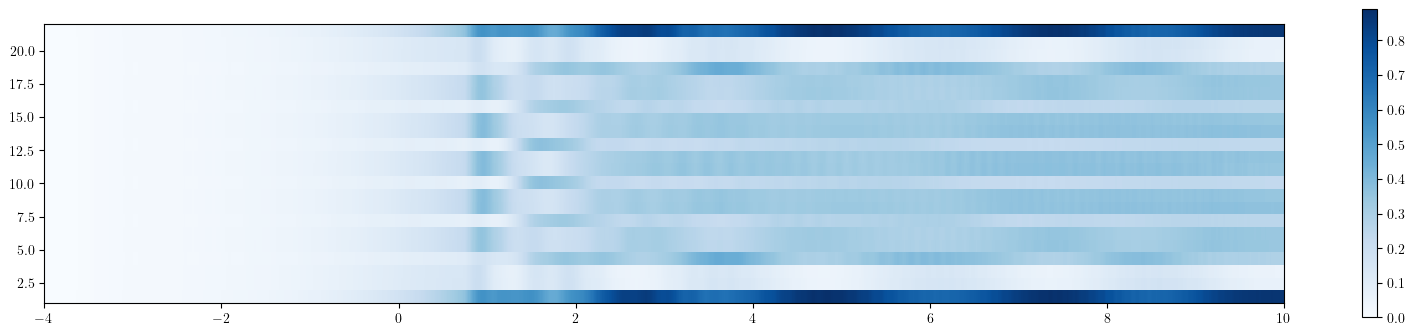

In [4826]:
plt.figure(figsize = (20,4))
plt.imshow(np.real(Nz_expect).T, interpolation='none',  extent = [delta_min/omega_max, delta_max/omega_max, 1, N], aspect = 0.15, cmap='Blues')
plt.colorbar()